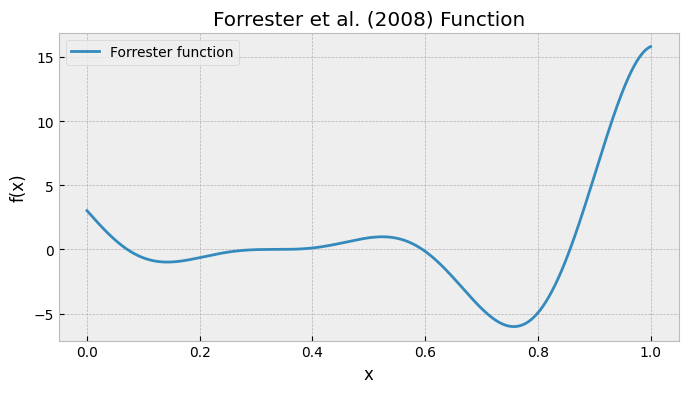

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from benchmarks import Forrester
import torch 

f = Forrester()

# Create a fine grid on [0,1]
x = torch.linspace(0, 1, 1000).unsqueeze(-1) 
y = f(x).squeeze(-1) 

# Plot
plt.figure(figsize=(8,4))
plt.plot(x, y, label='Forrester function', linewidth=2)
plt.title('Forrester et al. (2008) Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


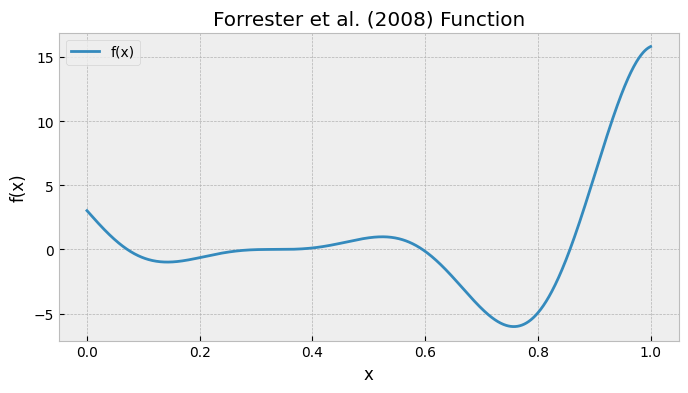

In [26]:
# 1. instantiate
f = Forrester()

# 2. make a grid of 1000 points in [0,1]
x = torch.linspace(0, 1, 1000).unsqueeze(-1)  # shape (1000,1)

# 3. evaluate
y = f(x).squeeze(-1)                          # shape (1000,)

# 4. plot (convert to NumPy)
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), y.numpy(), label="f(x)")
plt.title("Forrester et al. (2008) Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

In [27]:
import torch
import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

In [28]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

In [29]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [30]:
bound = 5

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(2)
train_x = torch.rand(size=(1, 1)) * 2 * bound - bound
train_y = forrester_1d(train_x)

# Set the number of initial points
n_initial_points = 10

# Set random seed for reproducibility
torch.manual_seed(2)

# Generate 10 random points in [-bound, bound]
train_x = torch.rand(size=(n_initial_points, 1)) * 2 * bound - bound

# Compute the function values for the initial points
train_y = forrester_1d(train_x)

# Print initial points and their function values
print(torch.hstack([train_x, train_y.unsqueeze(1)]))

tensor([[ 1.1470,  1.8423],
        [-1.1899,  1.0027],
        [ 1.3711,  2.1240],
        [-0.2554,  0.8895],
        [ 2.1359,  1.0222],
        [ 1.1904,  1.9072],
        [-0.5747,  0.9728],
        [-4.0423,  0.6349],
        [ 1.1416,  1.8341],
        [-4.4267,  2.2678]])


In [31]:
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

model, likelihood = fit_gp_model(train_x, train_y)

tensor([[1.0000, 1.6054],
        [2.0000, 1.5029]])


  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

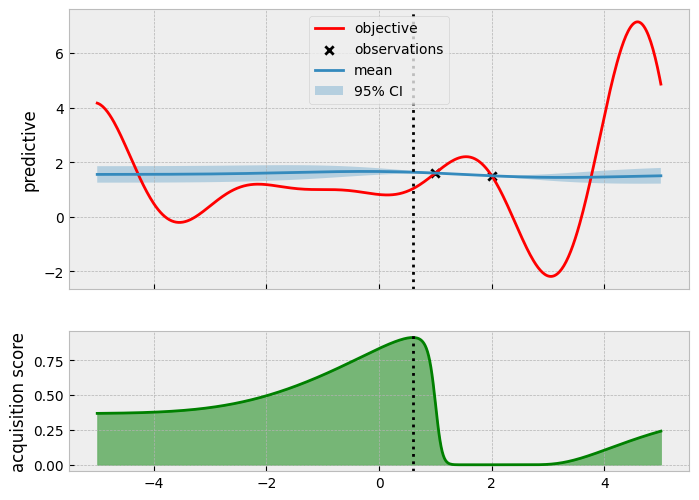

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

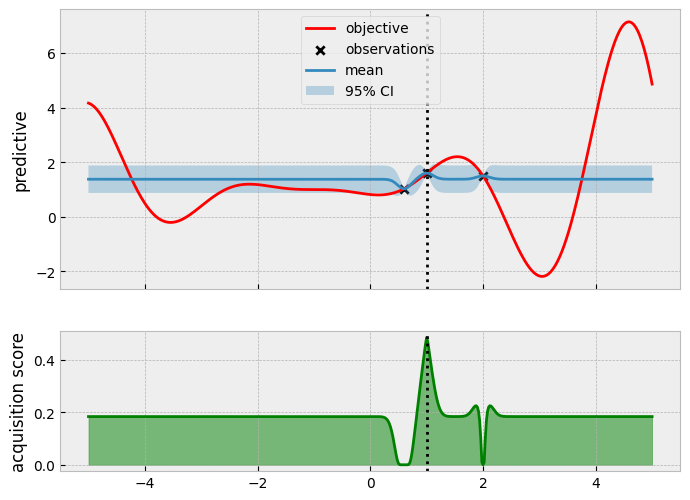

iteration 2
incumbent tensor([1.0036]) tensor(1.6114)


  0%|          | 0/500 [00:00<?, ?it/s]

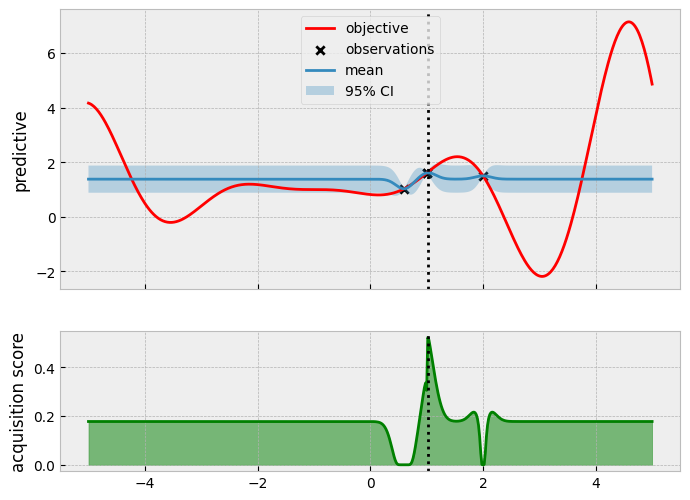

iteration 3
incumbent tensor([1.0238]) tensor(1.6448)


  0%|          | 0/500 [00:00<?, ?it/s]

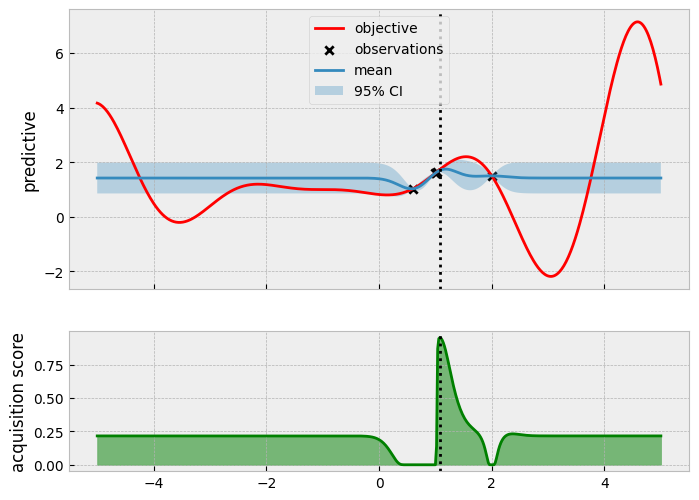

iteration 4
incumbent tensor([1.0790]) tensor(1.7349)


  0%|          | 0/500 [00:00<?, ?it/s]

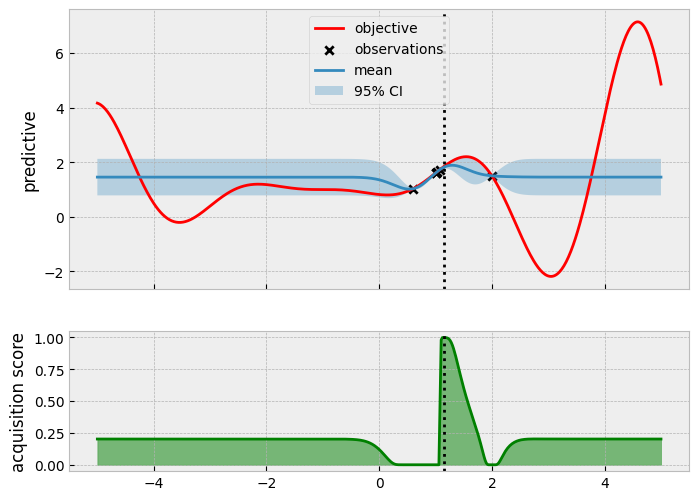

iteration 5
incumbent tensor([1.1446]) tensor(1.8388)


  0%|          | 0/500 [00:00<?, ?it/s]

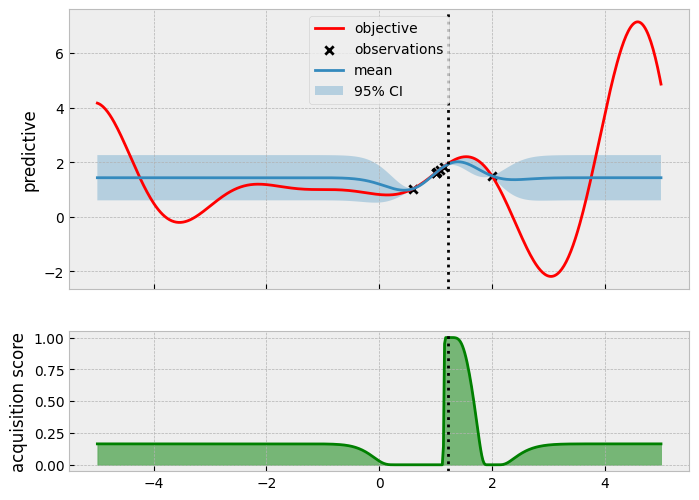

iteration 6
incumbent tensor([1.2272]) tensor(1.9592)


  0%|          | 0/500 [00:00<?, ?it/s]

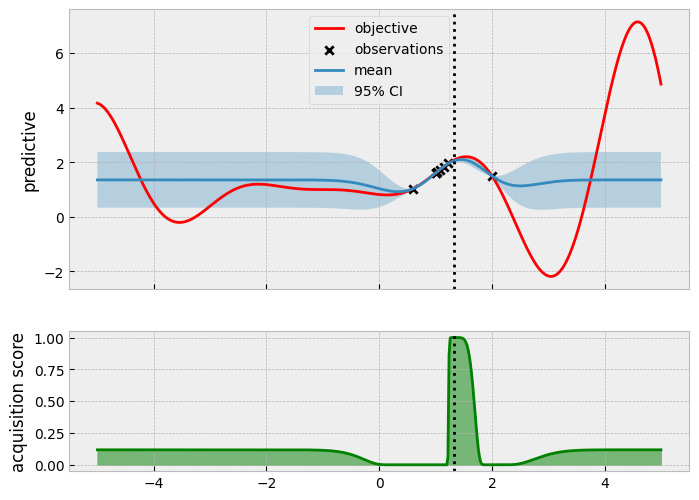

iteration 7
incumbent tensor([1.3226]) tensor(2.0765)


  0%|          | 0/500 [00:00<?, ?it/s]

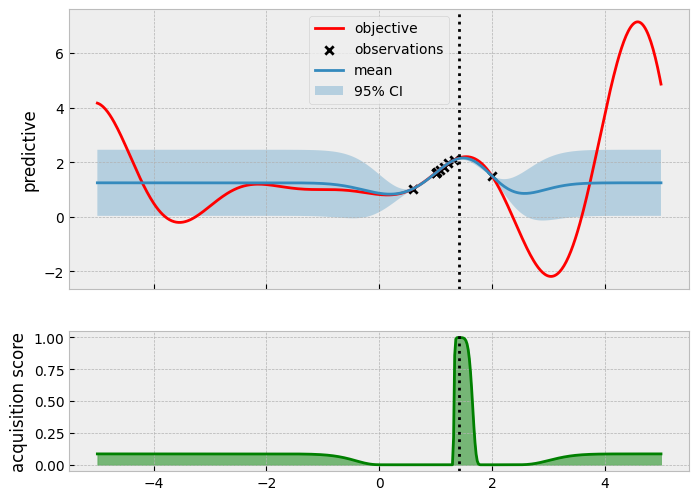

iteration 8
incumbent tensor([1.4179]) tensor(2.1604)


  0%|          | 0/500 [00:00<?, ?it/s]

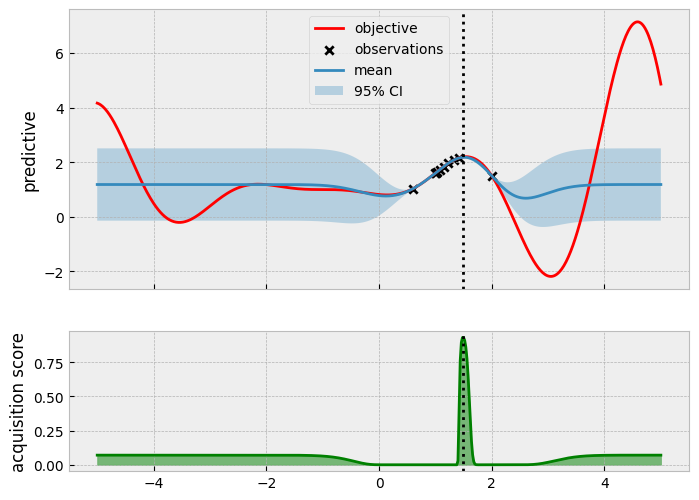

iteration 9
incumbent tensor([1.4892]) tensor(2.1956)


  0%|          | 0/500 [00:00<?, ?it/s]

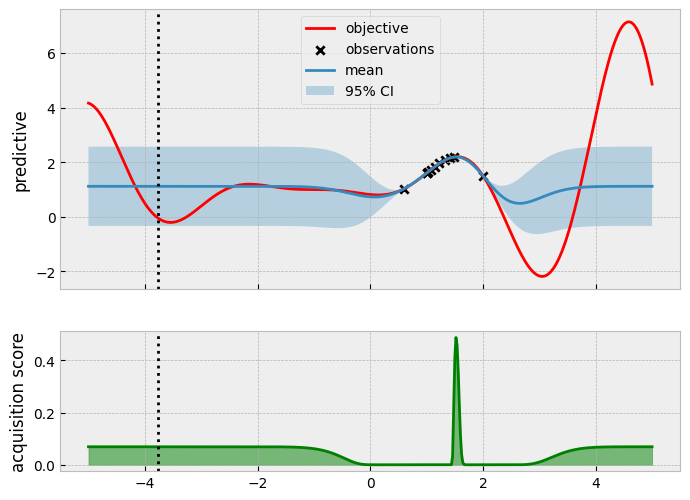

In [32]:
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

tensor([[ 1.1470,  1.8423],
        [-1.1899,  1.0027],
        [ 1.3711,  2.1240],
        [-0.2554,  0.8895],
        [ 2.1359,  1.0222],
        [ 1.1904,  1.9072],
        [-0.5747,  0.9728],
        [-4.0423,  0.6349],
        [ 1.1416,  1.8341],
        [-4.4267,  2.2678]])


  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0
incumbent tensor([-4.4267]) tensor(2.2678)


  0%|          | 0/500 [00:00<?, ?it/s]

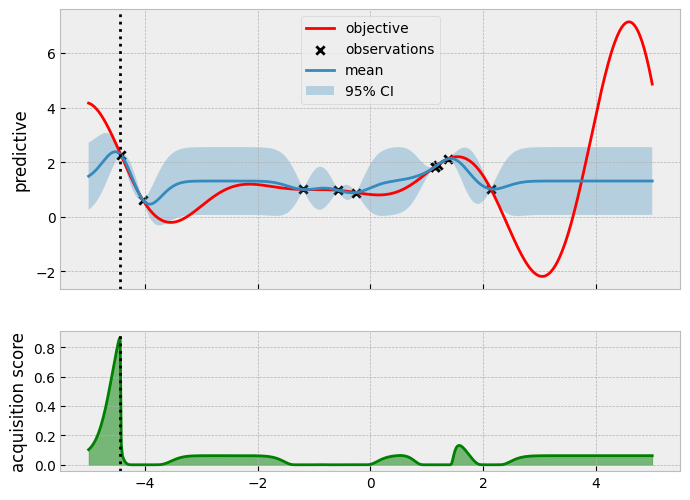

iteration 1
incumbent tensor([-4.4434]) tensor(2.3462)


  0%|          | 0/500 [00:00<?, ?it/s]

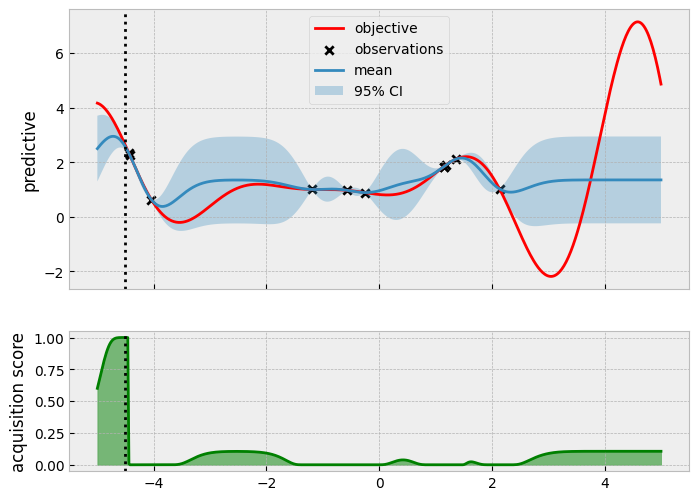

iteration 2
incumbent tensor([-4.5009]) tensor(2.6139)


  0%|          | 0/500 [00:00<?, ?it/s]

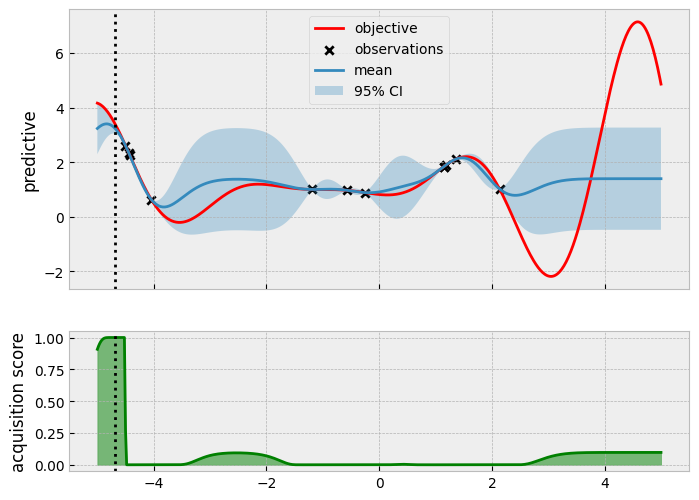

iteration 3
incumbent tensor([-4.6791]) tensor(3.3813)


  0%|          | 0/500 [00:00<?, ?it/s]

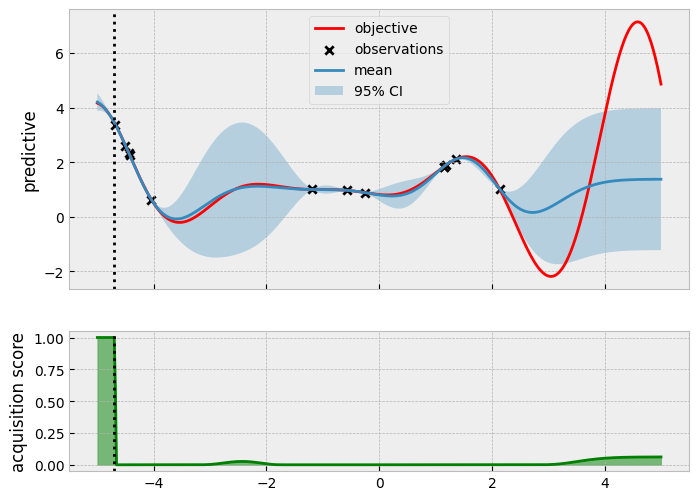

iteration 4
incumbent tensor([-4.6965]) tensor(3.4477)


  0%|          | 0/500 [00:00<?, ?it/s]

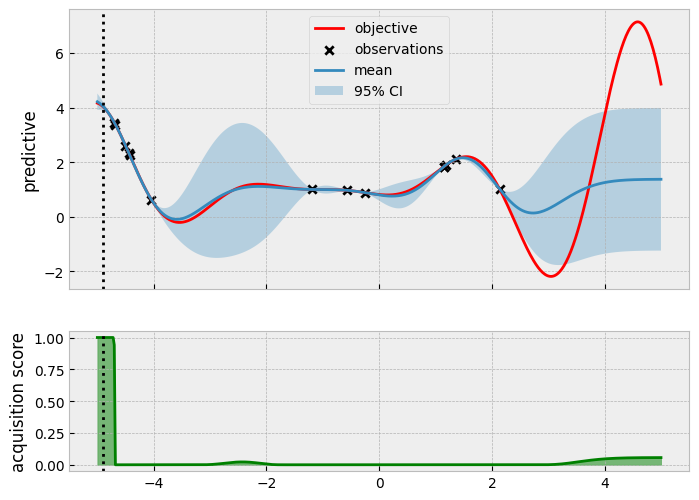

iteration 5
incumbent tensor([-4.8940]) tensor(4.0261)


  0%|          | 0/500 [00:00<?, ?it/s]

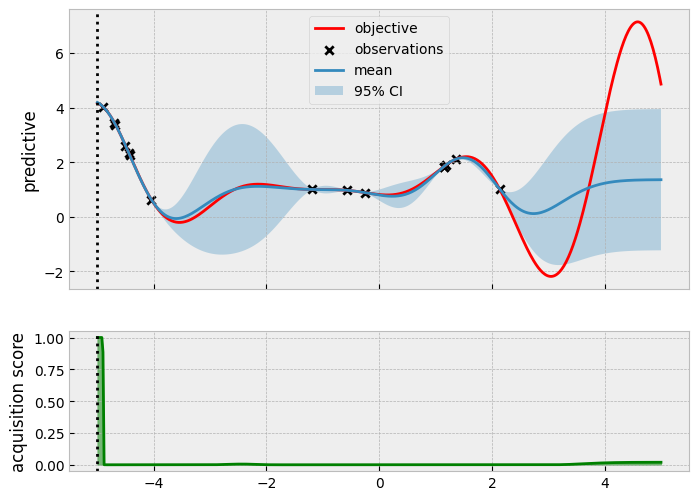

iteration 6
incumbent tensor([-4.9999]) tensor(4.1659)


  0%|          | 0/500 [00:00<?, ?it/s]

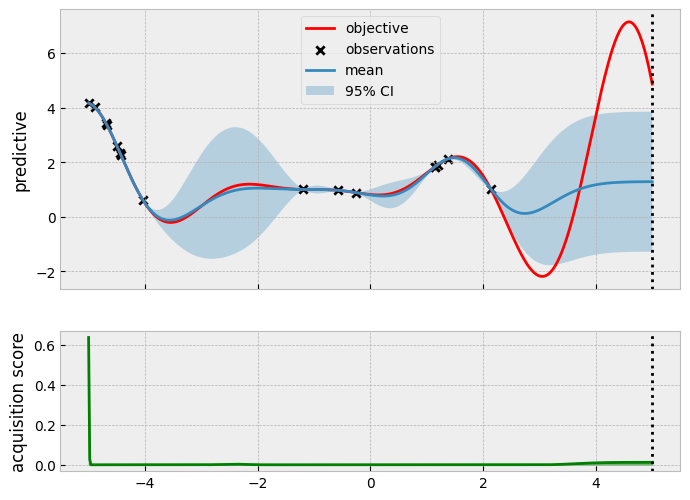

iteration 7
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

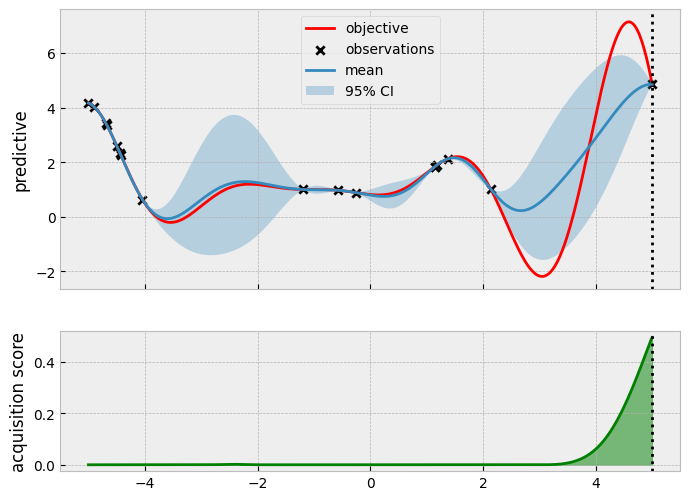

iteration 8
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

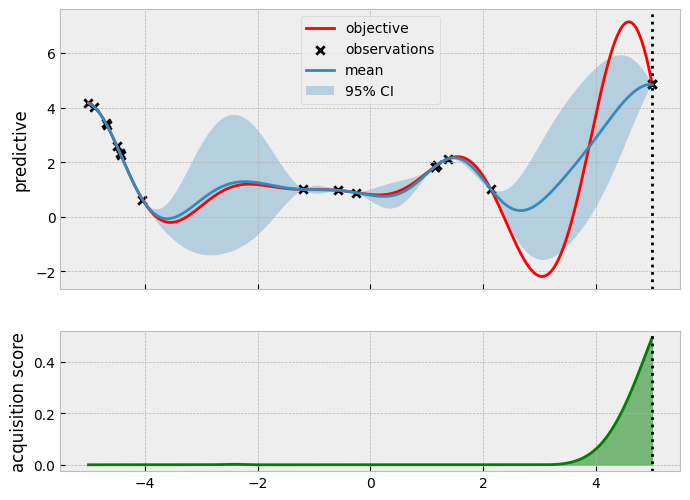

iteration 9
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

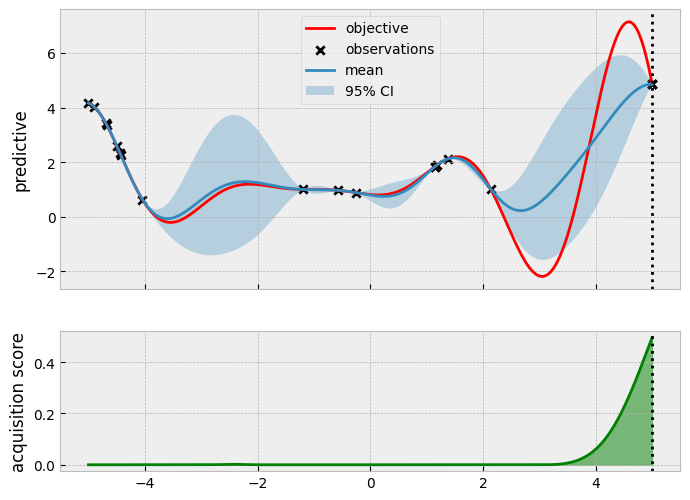

In [33]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

# Set bounds and initialize data
bound = 5
xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

# Initialize with 10 random points
n_initial_points = 10
torch.manual_seed(2)
train_x = torch.rand(size=(n_initial_points, 1)) * 2 * bound - bound
train_y = forrester_1d(train_x)

# Print initial points and their function values
print(torch.hstack([train_x, train_y.unsqueeze(1)]))

# Fit initial GP model
model, likelihood = fit_gp_model(train_x, train_y)

# Run Bayesian optimization for num_queries iterations
num_queries = 10
for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

tensor([[ 0.6147, -0.6629],
        [ 0.3810,  0.0443],
        [ 0.6371, -1.6037],
        [ 0.4745,  0.7116],
        [ 0.7136, -5.1476],
        [ 0.6190, -0.8314],
        [ 0.4425,  0.4148],
        [ 0.0958, -0.5826],
        [ 0.6142, -0.6425],
        [ 0.0573,  0.4653]])


  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0
incumbent tensor([0.4745]) tensor(0.7116)


  0%|          | 0/500 [00:00<?, ?it/s]

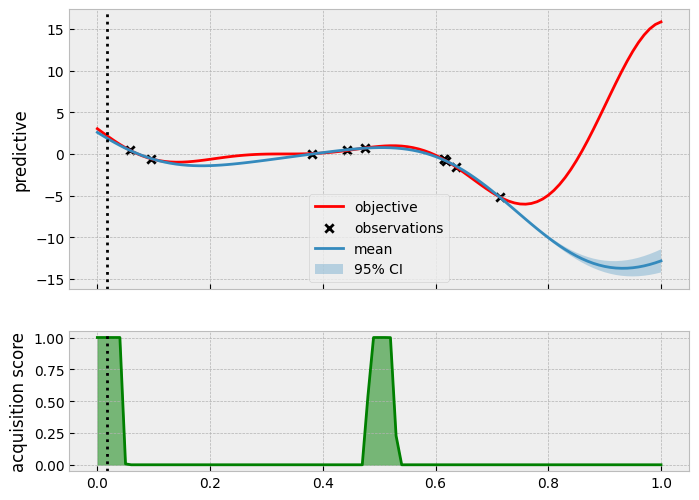

iteration 1
incumbent tensor([0.0171]) tensor(2.1878)


  0%|          | 0/500 [00:00<?, ?it/s]

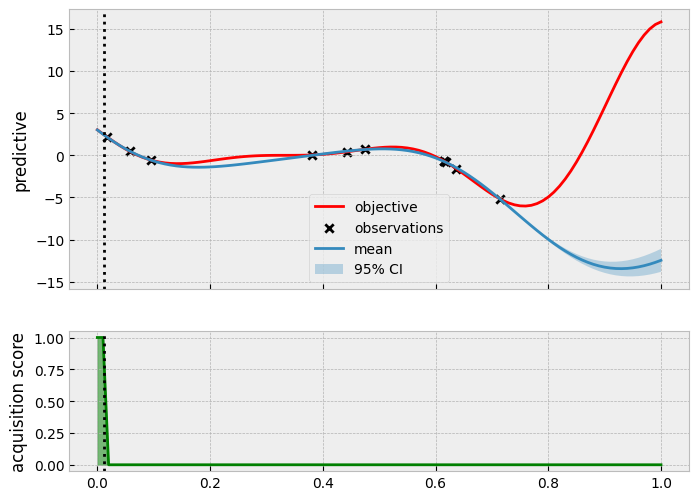

iteration 2
incumbent tensor([0.0110]) tensor(2.4820)


  0%|          | 0/500 [00:00<?, ?it/s]

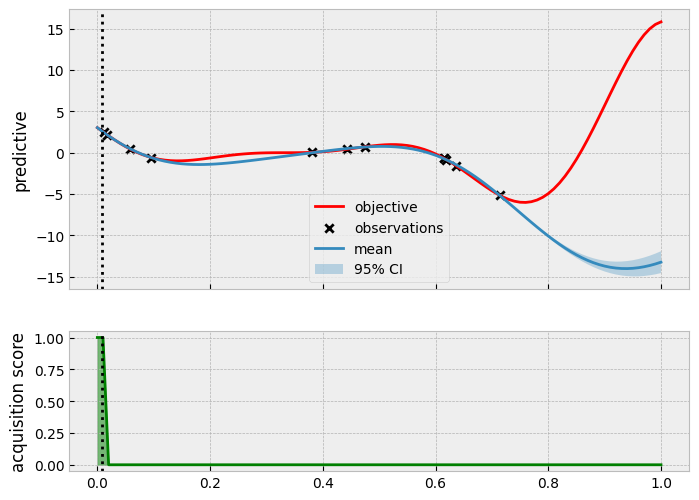

iteration 3
incumbent tensor([0.0079]) tensor(2.6377)


  0%|          | 0/500 [00:00<?, ?it/s]

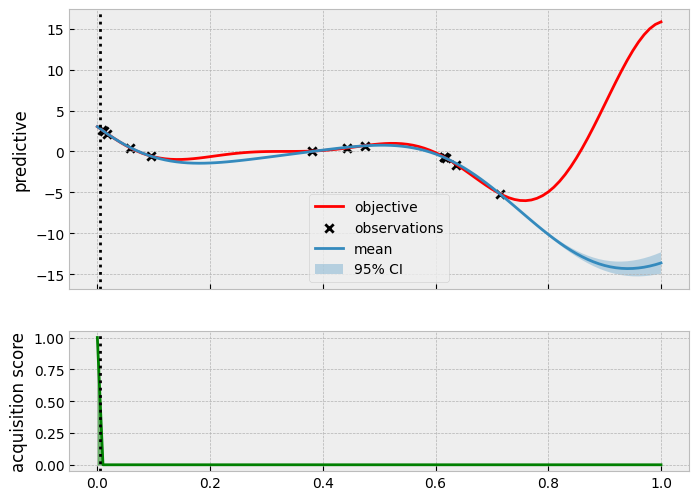

iteration 4
incumbent tensor([0.0048]) tensor(2.7905)


  0%|          | 0/500 [00:00<?, ?it/s]

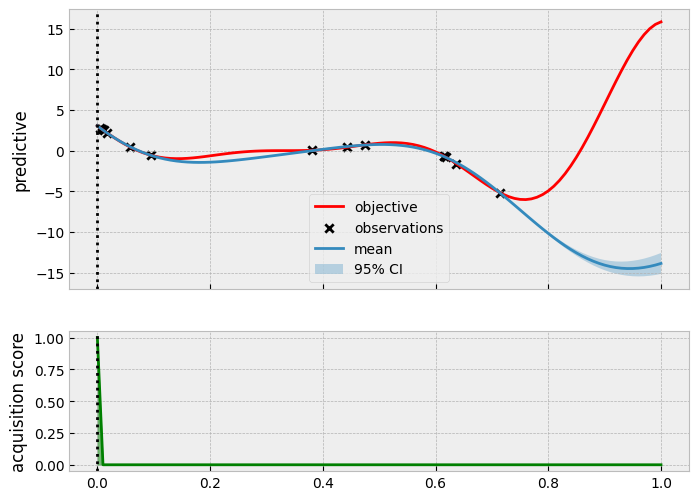

iteration 5
incumbent tensor([7.0541e-05]) tensor(3.0237)


  0%|          | 0/500 [00:00<?, ?it/s]

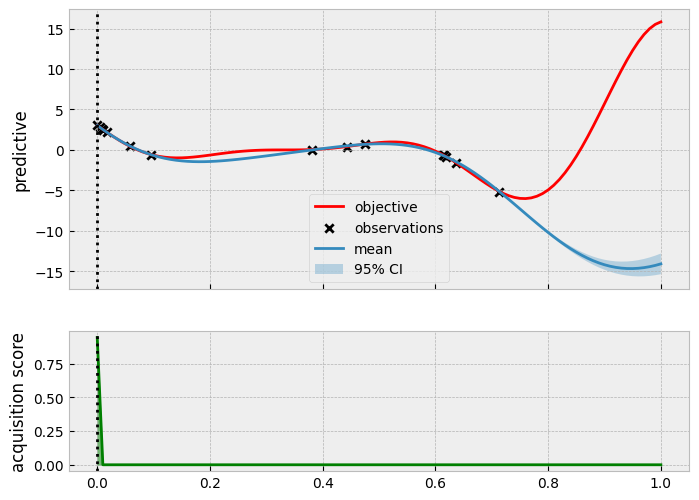

iteration 6
incumbent tensor([0.]) tensor(3.0272)


  0%|          | 0/500 [00:00<?, ?it/s]

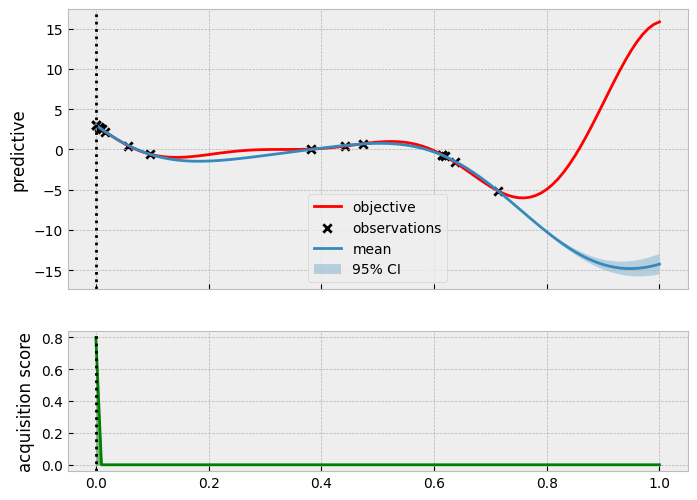

iteration 7
incumbent tensor([0.]) tensor(3.0272)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


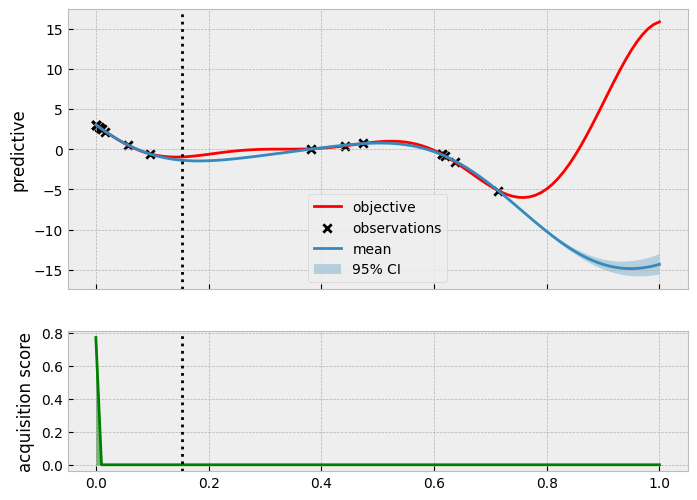

iteration 8
incumbent tensor([0.]) tensor(3.0272)


  0%|          | 0/500 [00:00<?, ?it/s]

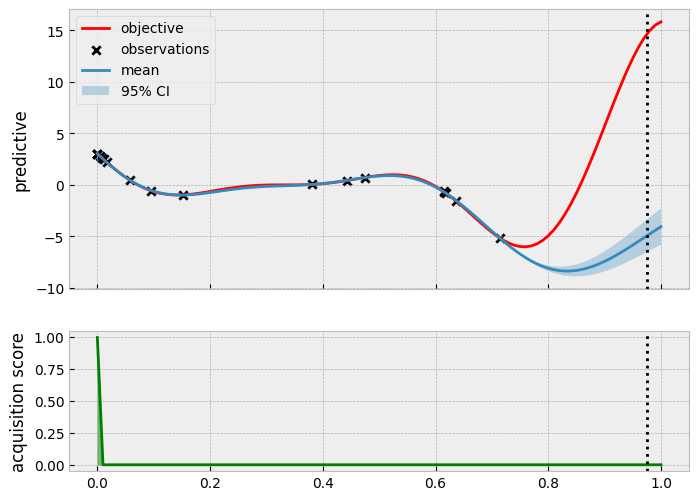

iteration 9
incumbent tensor([0.9757]) tensor(14.6954)


  0%|          | 0/500 [00:00<?, ?it/s]

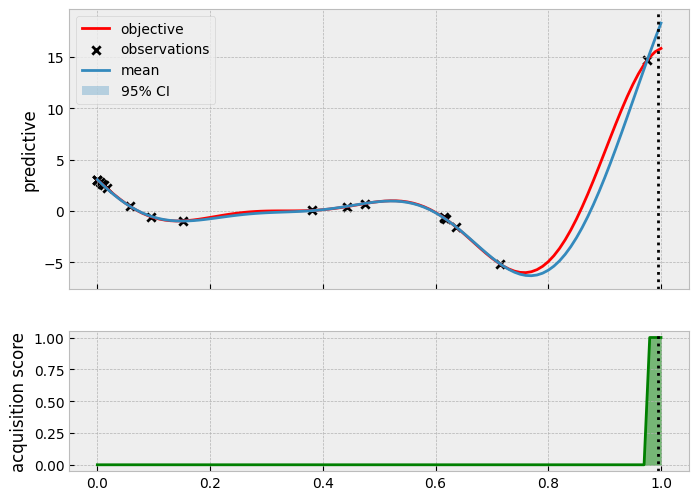

In [40]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

class Forrester:
    """f(x) = (6x − 2)^2 sin(12x − 4),  x ∈ [0,1]"""
    def __init__(self):
        self.bounds = torch.tensor([[0.0], [1.0]])
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return (((6*x - 2)**2) * torch.sin(12*x - 4)).squeeze(-1)

def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI Erickson")

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

# Initialize Forrester function and bounds
forrester = Forrester()
bounds = forrester.bounds  # [0, 1]

# Set up grid for visualization
xs = torch.linspace(bounds[0, 0], bounds[1, 0], 101).unsqueeze(1)
ys = forrester(xs)

# Initialize with 10 random points in [0, 1]
n_initial_points = 10
torch.manual_seed(2)
train_x = torch.rand(size=(n_initial_points, 1))  # Uniformly sampled from [0, 1]
train_y = forrester(train_x)

# Print initial points and their function values
print(torch.hstack([train_x, train_y.unsqueeze(1)]))

# Fit initial GP model
model, likelihood = fit_gp_model(train_x, train_y)

# Run Bayesian optimization for num_queries iterations
num_queries = 10
for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

tensor([[ 0.6147, -0.6629],
        [ 0.3810,  0.0443],
        [ 0.6371, -1.6037],
        [ 0.4745,  0.7116],
        [ 0.7136, -5.1476],
        [ 0.6190, -0.8314],
        [ 0.4425,  0.4148],
        [ 0.0958, -0.5826],
        [ 0.6142, -0.6425],
        [ 0.0573,  0.4653]])


  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0
incumbent tensor([0.7136]) tensor(-5.1476)


  0%|          | 0/500 [00:00<?, ?it/s]

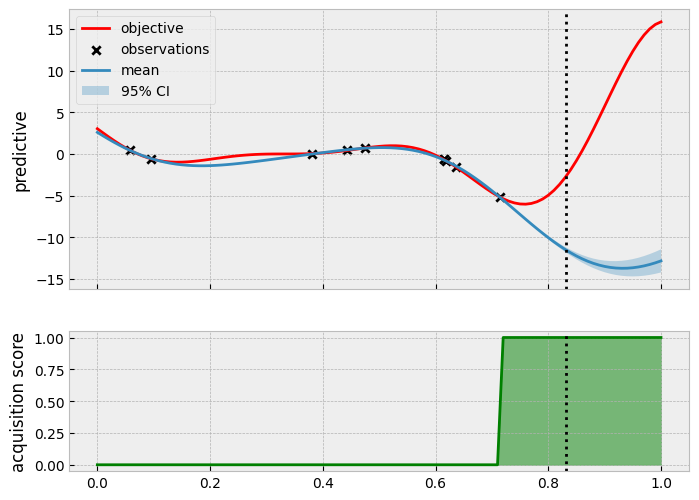

iteration 1
incumbent tensor([0.7136]) tensor(-5.1476)


  0%|          | 0/500 [00:00<?, ?it/s]

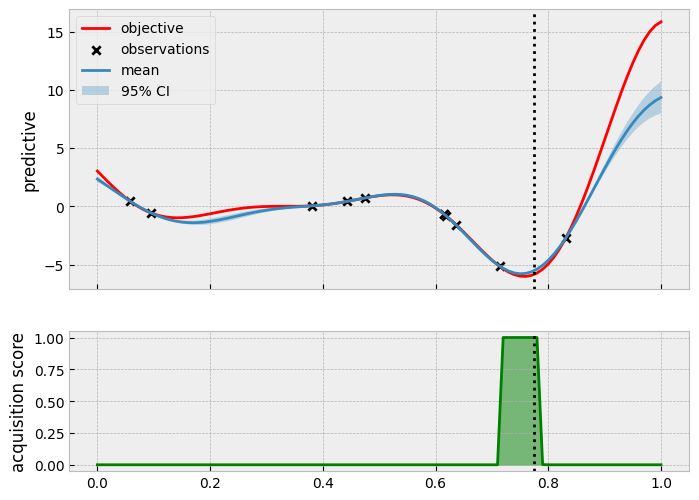

iteration 2
incumbent tensor([0.7753]) tensor(-5.8386)


  0%|          | 0/500 [00:00<?, ?it/s]

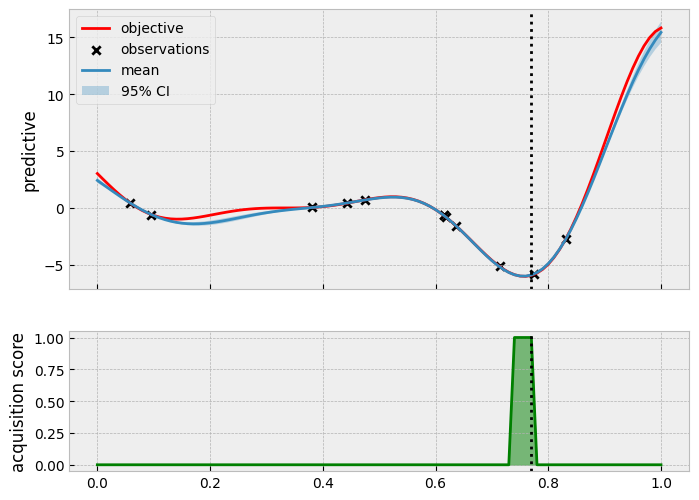

iteration 3
incumbent tensor([0.7687]) tensor(-5.9488)


  0%|          | 0/500 [00:00<?, ?it/s]

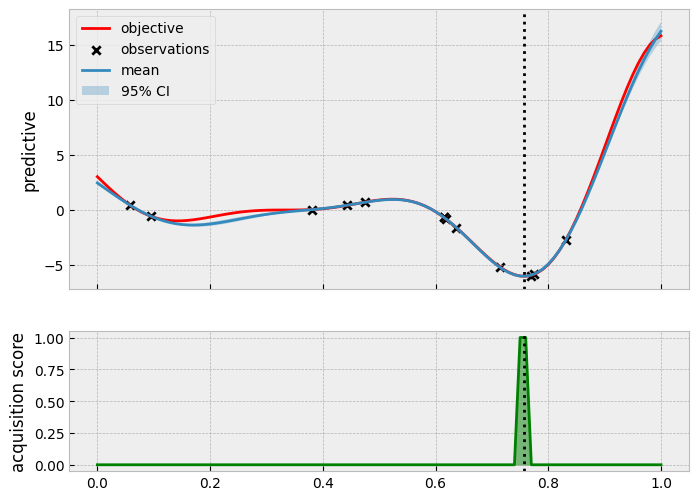

iteration 4
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:677: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


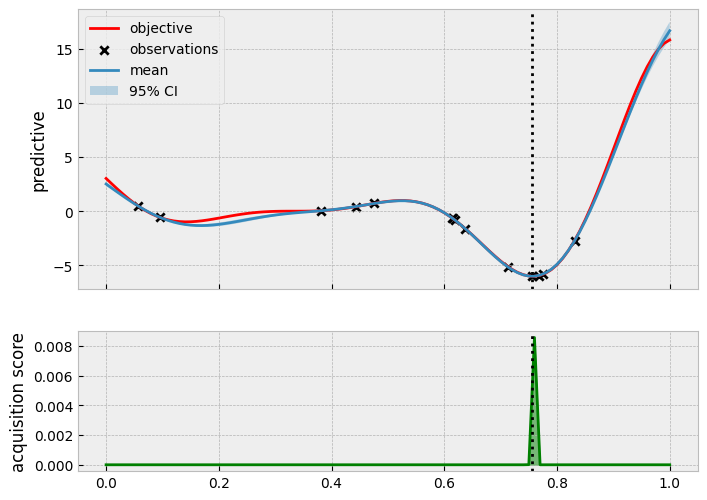

iteration 5
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

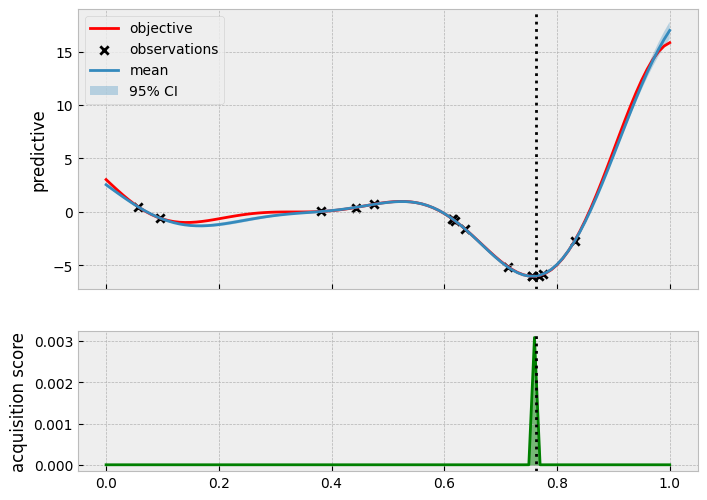

iteration 6
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

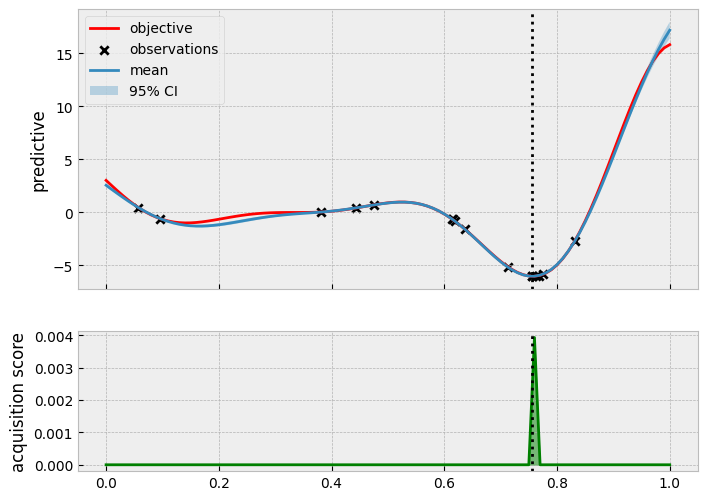

iteration 7
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

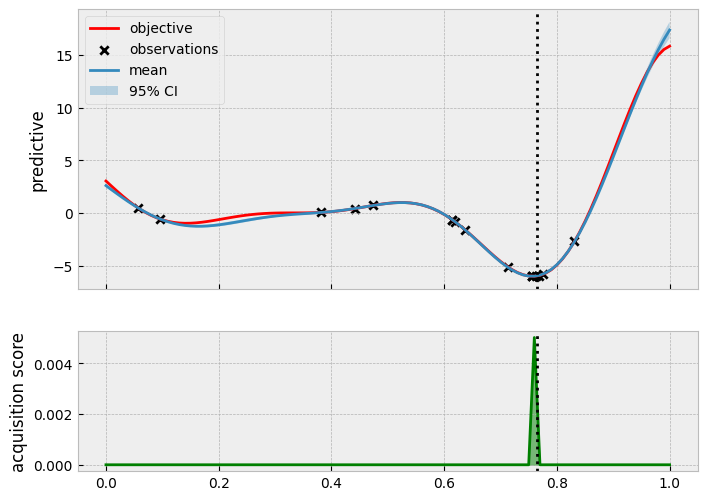

iteration 8
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

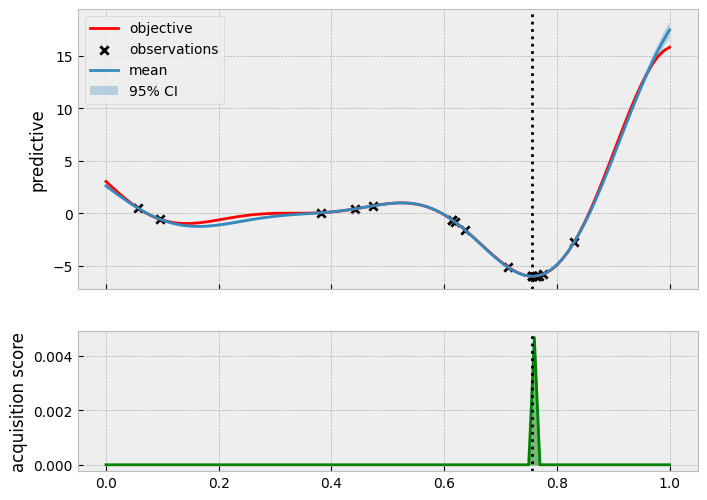

iteration 9
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

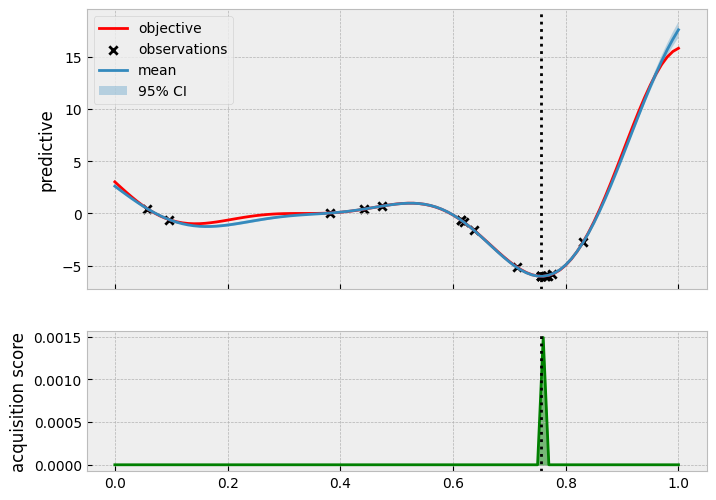

In [41]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

class Forrester:
    """f(x) = (6x − 2)^2 sin(12x − 4),  x ∈ [0,1]"""
    def __init__(self):
        self.bounds = torch.tensor([[0.0], [1.0]])
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return (((6*x - 2)**2) * torch.sin(12*x - 4)).squeeze(-1)

def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

# Initialize Forrester function and bounds
forrester = Forrester()
bounds = forrester.bounds  # [0, 1]

# Set up grid for visualization
xs = torch.linspace(bounds[0, 0], bounds[1, 0], 101).unsqueeze(1)
ys = forrester(xs)

# Initialize with 10 random points in [0, 1]
n_initial_points = 10
torch.manual_seed(2)
train_x = torch.rand(size=(n_initial_points, 1))  # Uniformly sampled from [0, 1]
train_y = forrester(train_x)

# Print initial points and their function values
print(torch.hstack([train_x, train_y.unsqueeze(1)]))

# Fit initial GP model
model, likelihood = fit_gp_model(train_x, train_y)

# Run Bayesian optimization for num_queries iterations
num_queries = 10
for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmin()], train_y.min())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.min(), maximize=False
    )
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

/var/folders/mg/l5f3xml94wjb2ks03kfgl9840000gn/T/ipykernel_46090/320643126.py:41: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp  = SingleTaskGP(X, Y)
/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/var/folders/mg/l5f3xml94wjb2ks03kfgl9840000gn/T/ipykernel_46090/320643126.py:41: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp  = SingleTaskGP(X, Y)
/opt/anaconda3

Best value found: 308.1290588378906
At location:     tensor([-5.,  0.])


/var/folders/mg/l5f3xml94wjb2ks03kfgl9840000gn/T/ipykernel_46090/320643126.py:41: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp  = SingleTaskGP(X, Y)
/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


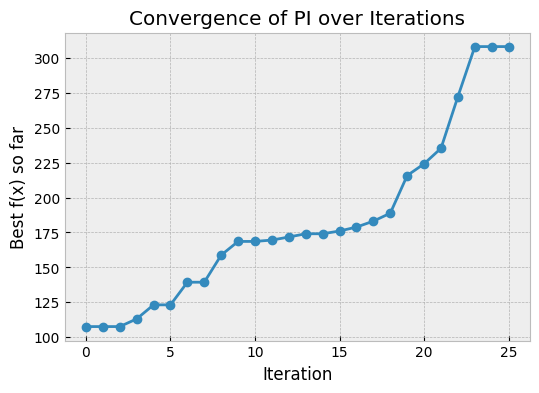

In [44]:
import torch
from torch.quasirandom import SobolEngine

from benchmarks import Forrester, Branin, Rosenbrock, Hartmann
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import (
    ExpectedImprovement,
    ProbabilityOfImprovement,
    UpperConfidenceBound,
    LogExpectedImprovement,
)
from botorch.optim import optimize_acqf
import matplotlib.pyplot as plt

# — pick one objective —
f = Branin()        # example: Branin; swap to Forrester(), Rosenbrock(dim=2), Hartmann(dim=3)

# use native bounds or override to [0,1]^d
bounds = f.bounds   # torch.stack([torch.zeros(d), torch.ones(d)])
d = bounds.size(-1)

# ==== initial design settings ====
n_init = 10      # number of initial points to seed the GP
sobol  = SobolEngine(d, scramble=True)
X      = bounds[0] + (bounds[1] - bounds[0]) * sobol.draw(n_init)
Y      = f(X).unsqueeze(-1)

# record best-so-far
best_per_iter = [Y.max().item()]

# ==== BO settings ====
acq_name = "PI"    # "EI" | "PI" | "LCB"
n_iter   = 25       # number of BO iterations
beta     = 2.0      # exploration weight for UCB

# ==== BO loop ==== 
for iteration in range(n_iter):
    # fit GP
    gp  = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # choose acquisition
    best_f = Y.max()
    if acq_name.upper() == "EI":
        acq = LogExpectedImprovement(gp, best_f=best_f, maximize=True)
    elif acq_name.upper() in {"PI", "POI"}:
        acq = ProbabilityOfImprovement(gp, best_f=best_f, maximize=True)
    else:  # LCB or UCB
        acq = UpperConfidenceBound(gp, beta=beta, maximize=True)

    # optimize acquisition
    candidate, _ = optimize_acqf(
        acq, bounds=bounds, q=1,
        num_restarts=10, raw_samples=256
    )

    # evaluate and update dataset
    new_y = f(candidate).unsqueeze(-1)
    X     = torch.cat([X, candidate])
    Y     = torch.cat([Y, new_y])

    # update record
    best_per_iter.append(Y.max().item())

# ==== report ====
best_idx = torch.argmax(Y)
print("Best value found:", Y[best_idx].item())
print("At location:    ", X[best_idx])

# ==== plot convergence ====
plt.figure(figsize=(6,4))
plt.plot(range(len(best_per_iter)), best_per_iter, marker='o')
plt.title(f"Convergence of {acq_name} over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best f(x) so far")
plt.grid(True)
plt.show()

tensor([[ 0.6147, -0.6629],
        [ 0.3810,  0.0443],
        [ 0.6371, -1.6037],
        [ 0.4745,  0.7116],
        [ 0.7136, -5.1476],
        [ 0.6190, -0.8314],
        [ 0.4425,  0.4148],
        [ 0.0958, -0.5826],
        [ 0.6142, -0.6425],
        [ 0.0573,  0.4653]])


  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0
incumbent tensor([0.7136]) tensor(-5.1476)


  0%|          | 0/500 [00:00<?, ?it/s]

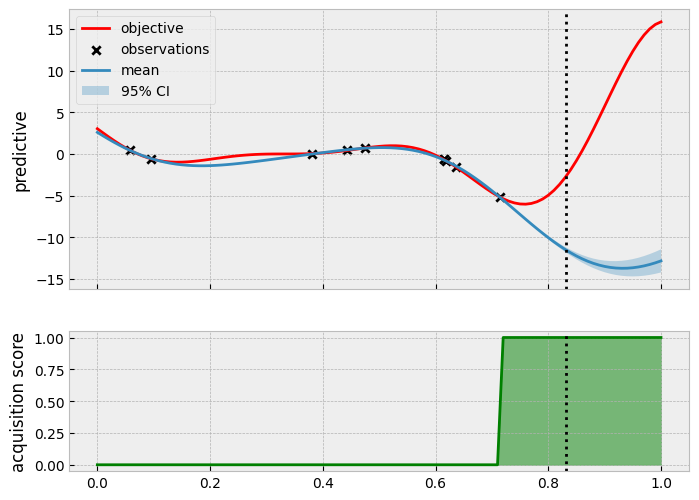

iteration 1
incumbent tensor([0.7136]) tensor(-5.1476)


  0%|          | 0/500 [00:00<?, ?it/s]

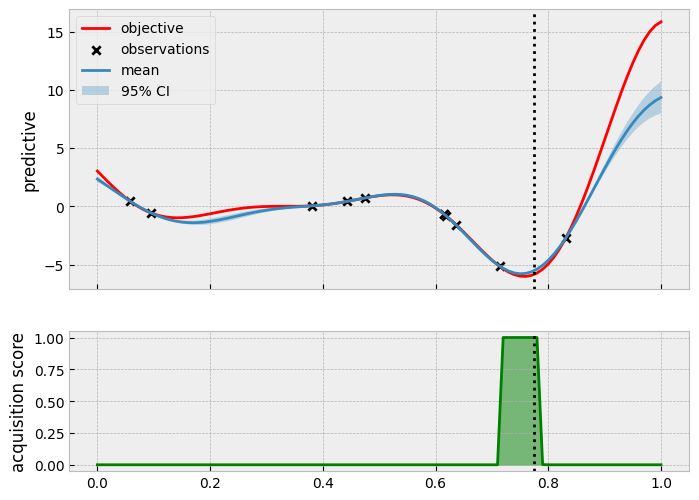

iteration 2
incumbent tensor([0.7753]) tensor(-5.8386)


  0%|          | 0/500 [00:00<?, ?it/s]

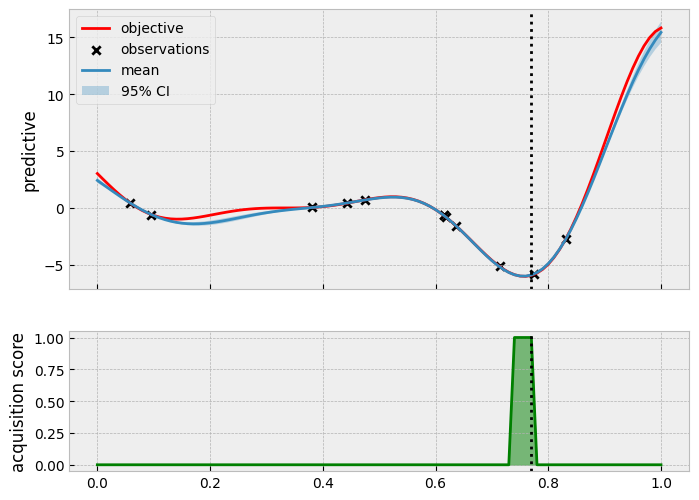

iteration 3
incumbent tensor([0.7687]) tensor(-5.9488)


  0%|          | 0/500 [00:00<?, ?it/s]

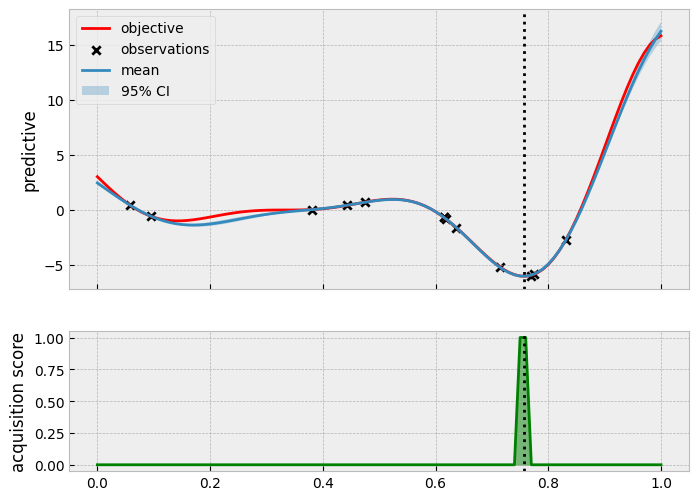

iteration 4
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:677: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


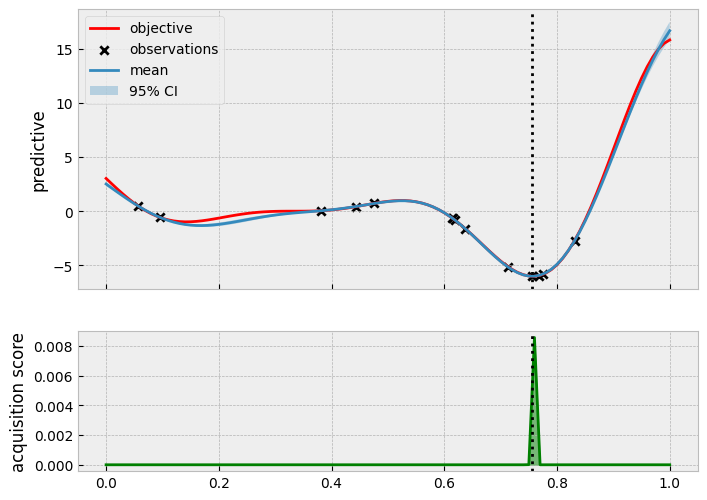

iteration 5
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

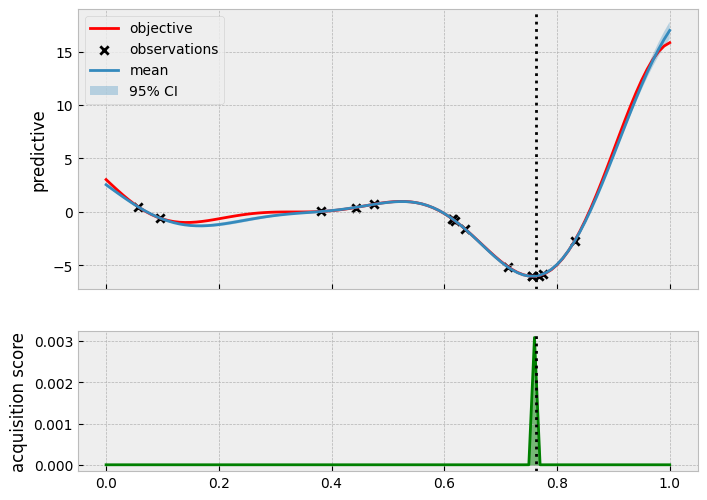

iteration 6
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

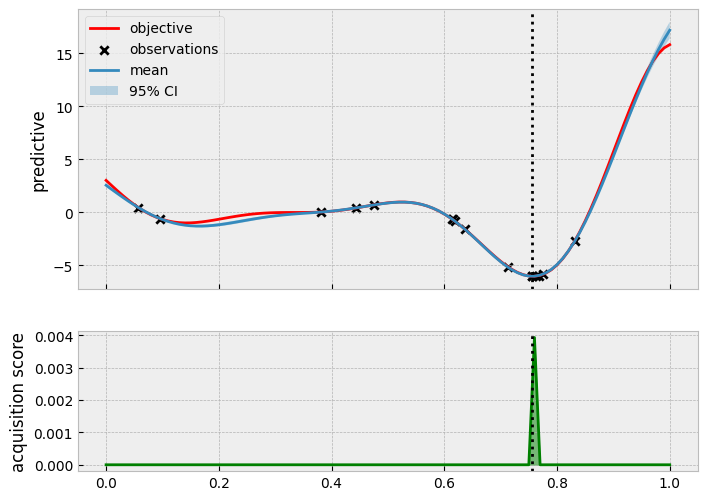

iteration 7
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

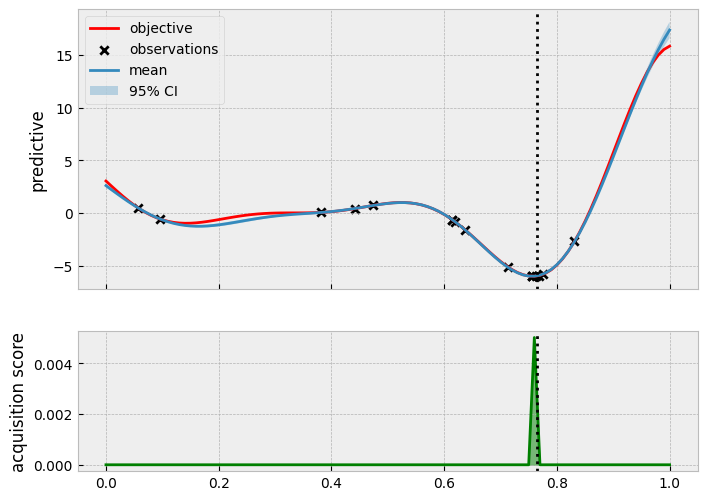

iteration 8
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

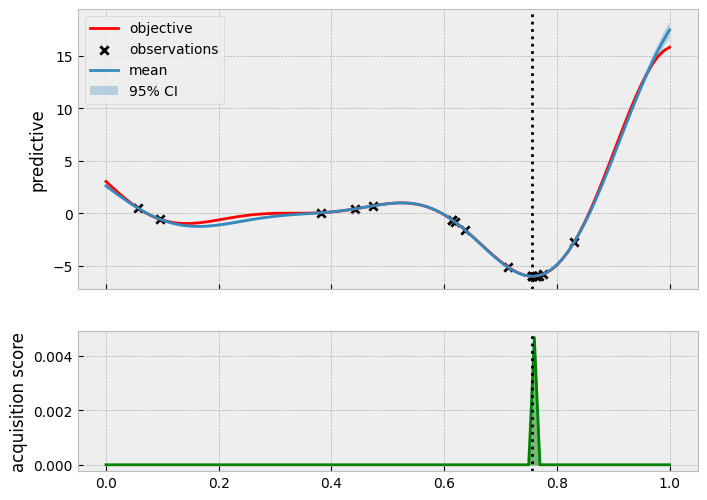

iteration 9
incumbent tensor([0.7565]) tensor(-6.0204)


  0%|          | 0/500 [00:00<?, ?it/s]

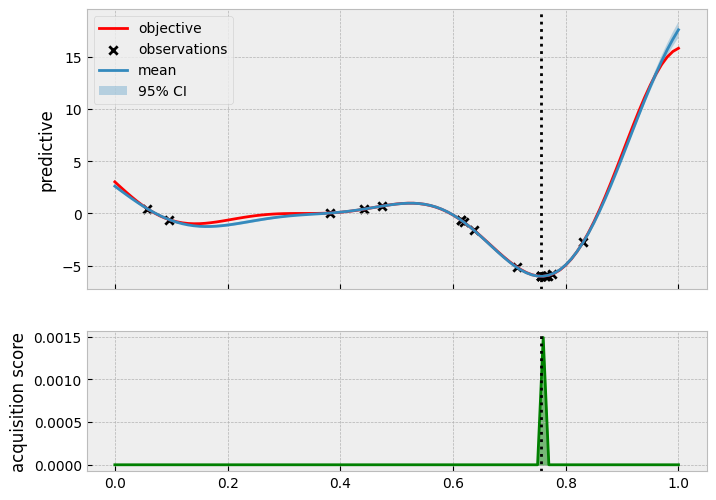

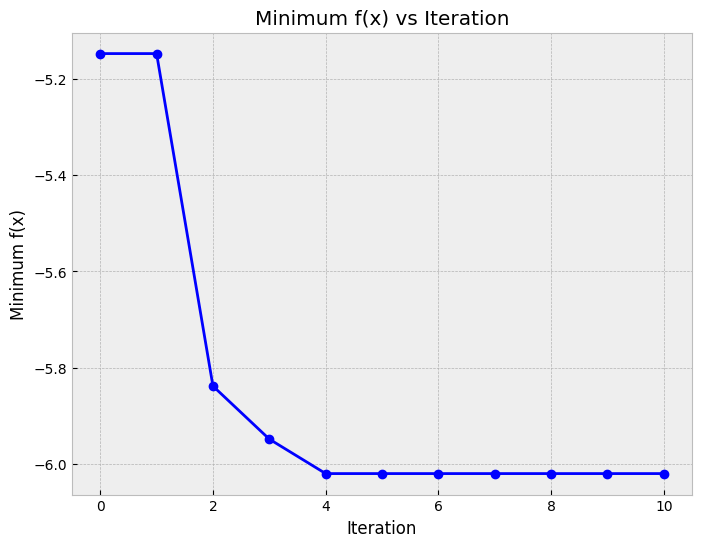

In [45]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

class Forrester:
    """f(x) = (6x − 2)^2 sin(12x − 4),  x ∈ [0,1]"""
    def __init__(self):
        self.bounds = torch.tensor([[0.0], [1.0]])
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return (((6*x - 2)**2) * torch.sin(12*x - 4)).squeeze(-1)

def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

# Initialize Forrester function and bounds
forrester = Forrester()
bounds = forrester.bounds  # [0, 1]

# Set up grid for visualization
xs = torch.linspace(bounds[0, 0], bounds[1, 0], 101).unsqueeze(1)
ys = forrester(xs)

# Initialize with 10 random points in [0, 1]
n_initial_points = 10
torch.manual_seed(2)
train_x = torch.rand(size=(n_initial_points, 1))  # Uniformly sampled from [0, 1]
train_y = forrester(train_x)

# Print initial points and their function values
print(torch.hstack([train_x, train_y.unsqueeze(1)]))

# Fit initial GP model
model, likelihood = fit_gp_model(train_x, train_y)

# Track minimum f(x) for each iteration
min_f_values = [train_y.min().item()]

# Run Bayesian optimization for num_queries iterations
num_queries = 10
for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmin()], train_y.min())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.min(), maximize=False
    )
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])
    
    # Store the minimum f(x) after this iteration
    min_f_values.append(train_y.min().item())

# Plot minimum f(x) vs iteration
plt.figure(figsize=(8, 6))
plt.plot(range(num_queries + 1), min_f_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Minimum f(x)')
plt.title('Minimum f(x) vs Iteration')
plt.grid(True)
plt.savefig('min_f_vs_iteration.png')

In [47]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("bmh")

from tqdm.notebook import tqdm

class Forrester:
    """f(x) = (6x − 2)^2 sin(12x − 4),  x ∈ [0,1]"""
    def __init__(self):
        self.bounds = torch.tensor([[0.0], [1.0]])
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return (((6*x - 2)**2) * torch.sin(12*x - 4)).squeeze(-1)

def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictiveRgb(255, 255, 255) #predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters), desc="Training GP"):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

# Initialize Forrester function and bounds
forrester = Forrester()
bounds = forrester.bounds  # [0, 1]

# Set up grid for visualization
xs = torch.linspace(bounds[0, 0], bounds[1, 0], 101).unsqueeze(1)
ys = forrester(xs)

# Parameters
n_initial_points = 10
num_queries = 10
num_runs = 10

# Store minimum f(x) for each run
all_min_f_values = []

for run in range(num_runs):
    print(f"\nRun {run + 1}/{num_runs}")
    
    # Set different random seed for each run
    torch.manual_seed(2 + run)
    
    # Initialize with 10 random points in [0, 1]
    train_x = torch.rand(size=(n_initial_points, 1))  # Uniformly sampled from [0, 1]
    train_y = forrester(train_x)

    # Print initial points and their function values
    print("Initial points:")
    print(torch.hstack([train_x, train_y.unsqueeze(1)]))

    # Fit initial GP model
    model, likelihood = fit_gp_model(train_x, train_y)

    # Track minimum f(x) for this run
    min_f_values = [train_y.min().item()]

    # Run Bayesian optimization
    for i in range(num_queries):
        print(f"Iteration {i}, incumbent x={train_x[train_y.argmin()].item():.4f}, f(x)={train_y.min().item():.4f}")

        model, likelihood = fit_gp_model(train_x, train_y)

        policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
            model, best_f=train_y.min(), maximize=False
        )
        
        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds=bounds,
            q=1,
            num_restarts=20,
            raw_samples=50,
        )

        # Comment out to avoid clutter
        # visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

        next_y = forrester(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])
        
        # Store the minimum f(x)
        min_f_values.append(train_y.min().item())

    # Store results for this run
    all_min_f_values.append(min_f_values)

    # Plot minimum f(x) vs iteration for this run
    plt.figure(figsize=(8, 6))
    plt.plot(range(num_queries + 1), min_f_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Iteration')
    plt.ylabel('Minimum f(x)')
    plt.title(f'Minimum f(x) vs Iteration (Run {run + 1})')
    plt.grid(True)
    plt.savefig(f'min_f_vs_iteration_run_{run + 1}.png')
    plt.close()

# Convert to numpy array for easier computation
all_min_f_values = np.array(all_min_f_values)  # Shape: (num_runs, num_queries + 1)

# Compute mean, std, and 95% CI
mean_f = np.mean(all_min_f_values, axis=0)
std_f = np.std(all_min_f_values, axis=0)
ci_95 = 1.96 * std_f / np.sqrt(num_runs)  # 95% CI: z=1.96 for normal distribution

# Plot convergence with mean, std, and CI
plt.figure(figsize=(10, 6))
iterations = range(num_queries + 1)

# Plot mean
plt.plot(iterations, mean_f, marker='o', linestyle='-', color='b', label='Mean Minimum f(x)')

# Plot 95% CI
plt.fill_between(
    iterations,
    mean_f - ci_95,
    mean_f + ci_95,
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Plot mean ± std (optional, for additional context)
plt.fill_between(
    iterations,
    mean_f - std_f,
    mean_f + std_f,
    color='g',
    alpha=0.1,
    label='Mean ± Std'
)

plt.xlabel('Iteration')
plt.ylabel('Minimum f(x)')
plt.title('Convergence Plot: Mean, Std, and 95% CI over 10 Runs')
plt.grid(True)
plt.legend()
plt.savefig('convergence_plot.png')
plt.close()


Run 1/10
Initial points:
tensor([[ 0.6147, -0.6629],
        [ 0.3810,  0.0443],
        [ 0.6371, -1.6037],
        [ 0.4745,  0.7116],
        [ 0.7136, -5.1476],
        [ 0.6190, -0.8314],
        [ 0.4425,  0.4148],
        [ 0.0958, -0.5826],
        [ 0.6142, -0.6425],
        [ 0.0573,  0.4653]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.7136, f(x)=-5.1476


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7136, f(x)=-5.1476


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7753, f(x)=-5.8386


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7687, f(x)=-5.9488


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7565, f(x)=-6.0204


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7565, f(x)=-6.0204


/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:677: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7565, f(x)=-6.0204


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7565, f(x)=-6.0204


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7565, f(x)=-6.0204


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7565, f(x)=-6.0204


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 2/10
Initial points:
tensor([[ 4.2635e-03,  2.8161e+00],
        [ 1.0557e-01, -7.4172e-01],
        [ 2.8584e-01, -4.3807e-02],
        [ 2.6955e-02,  1.7227e+00],
        [ 4.7161e-01,  6.8568e-01],
        [ 6.0116e-02,  3.6704e-01],
        [ 7.7187e-01, -5.9022e+00],
        [ 7.4370e-01, -5.9267e+00],
        [ 5.9442e-01,  2.0952e-02],
        [ 8.8786e-01,  4.0143e+00]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.7437, f(x)=-5.9267


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7639, f(x)=-5.9964


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7568, f(x)=-6.0206


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7569, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7571, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7571, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7573, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7573, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7573, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7573, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 3/10
Initial points:
tensor([[ 5.5964e-01,  7.6176e-01],
        [ 5.5909e-01,  7.6902e-01],
        [ 9.1457e-02, -4.9874e-01],
        [ 2.1000e-01, -5.4531e-01],
        [ 7.1946e-03,  2.6713e+00],
        [ 3.8962e-02,  1.1885e+00],
        [ 9.9289e-01,  1.5632e+01],
        [ 9.1311e-01,  7.5542e+00],
        [ 6.1858e-01, -8.1330e-01],
        [ 9.7439e-01,  1.4602e+01]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.6186, f(x)=-0.8133


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.1452, f(x)=-0.9853


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.6337, f(x)=-1.4484


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7060, f(x)=-4.8559


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7194, f(x)=-5.3480


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7506, f(x)=-5.9974


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7506, f(x)=-5.9974


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7637, f(x)=-5.9983


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7542, f(x)=-6.0159


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7566, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 4/10
Initial points:
tensor([[ 0.8303, -2.7977],
        [ 0.1261, -0.9416],
        [ 0.9075,  6.7635],
        [ 0.8199, -3.6619],
        [ 0.9201,  8.5215],
        [ 0.1166, -0.8710],
        [ 0.1644, -0.9223],
        [ 0.7379, -5.8330],
        [ 0.0333,  1.4368],
        [ 0.9942, 15.6764]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.7379, f(x)=-5.8330


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7665, f(x)=-5.9743


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7561, f(x)=-6.0201


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7580, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7580, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7580, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7580, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7580, f(x)=-6.0205


/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:677: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7580, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7580, f(x)=-6.0205


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 5/10
Initial points:
tensor([[ 0.5722,  0.5582],
        [ 0.5539,  0.8319],
        [ 0.9868, 15.3730],
        [ 0.6080, -0.4187],
        [ 0.2347, -0.3247],
        [ 0.4492,  0.4753],
        [ 0.6743, -3.4062],
        [ 0.7480, -5.9764],
        [ 0.5601,  0.7554],
        [ 0.1674, -0.9050]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.7480, f(x)=-5.9764


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7480, f(x)=-5.9764


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7480, f(x)=-5.9764


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7639, f(x)=-5.9966


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7639, f(x)=-5.9966


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7639, f(x)=-5.9966


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7639, f(x)=-5.9966


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7616, f(x)=-6.0103


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7616, f(x)=-6.0103


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7616, f(x)=-6.0103


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 6/10
Initial points:
tensor([[ 0.5349,  0.9674],
        [ 0.1988, -0.6509],
        [ 0.6592, -2.6585],
        [ 0.6569, -2.5443],
        [ 0.2328, -0.3403],
        [ 0.4251,  0.2701],
        [ 0.2071, -0.5729],
        [ 0.6297, -1.2759],
        [ 0.3653,  0.0138],
        [ 0.8513, -0.6558]])


/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.6592, f(x)=-2.6585


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.8009, f(x)=-4.9042


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7787, f(x)=-5.7608


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7359, f(x)=-5.7929


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7519, f(x)=-6.0059


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7568, f(x)=-6.0206


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7568, f(x)=-6.0206


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7568, f(x)=-6.0206


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7568, f(x)=-6.0207


/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:677: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7568, f(x)=-6.0207


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 7/10
Initial points:
tensor([[ 0.5979, -0.0845],
        [ 0.8453, -1.3133],
        [ 0.9464, 11.8937],
        [ 0.2965, -0.0208],
        [ 0.5138,  0.9711],
        [ 0.6443, -1.9390],
        [ 0.8991,  5.5791],
        [ 0.0141,  2.3336],
        [ 0.5785,  0.4301],
        [ 0.1218, -0.9139]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.6443, f(x)=-1.9390


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7408, f(x)=-5.8829


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7542, f(x)=-6.0157


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7552, f(x)=-6.0185


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 8/10
Initial points:
tensor([[ 0.6558, -2.4901],
        [ 0.3020, -0.0130],
        [ 0.4799,  0.7597],
        [ 0.7774, -5.7931],
        [ 0.9180,  8.2274],
        [ 0.9310,  9.9875],
        [ 0.2604, -0.1472],
        [ 0.9534, 12.6792],
        [ 0.3804,  0.0428],
        [ 0.4104,  0.1709]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.7774, f(x)=-5.7931


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7563, f(x)=-6.0202


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7563, f(x)=-6.0202


/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/optim/optimize.py:677: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 9/10
Initial points:
tensor([[ 4.5808e-01,  5.5874e-01],
        [ 4.8286e-01,  7.8484e-01],
        [ 3.1250e-01, -3.8666e-03],
        [ 6.1502e-01, -6.7531e-01],
        [ 2.1395e-01, -5.0822e-01],
        [ 4.1183e-01,  1.7937e-01],
        [ 6.9379e-01, -4.3319e+00],
        [ 9.6931e-01,  1.4202e+01],
        [ 6.1780e-01, -7.8249e-01],
        [ 3.3037e-01, -1.1285e-05]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.6938, f(x)=-4.3319


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7264, f(x)=-5.5632


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7486, f(x)=-5.9819


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7563, f(x)=-6.0203


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 10/10
Initial points:
tensor([[ 0.1490, -0.9802],
        [ 0.4866,  0.8150],
        [ 0.9857, 15.3140],
        [ 0.1684, -0.8988],
        [ 0.5839,  0.3027],
        [ 0.6936, -4.3231],
        [ 0.5831,  0.3235],
        [ 0.1284, -0.9537],
        [ 0.5721,  0.5596],
        [ 0.9248,  9.1652]])


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, incumbent x=0.6936, f(x)=-4.3231


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, incumbent x=0.7188, f(x)=-5.3273


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 2, incumbent x=0.7463, f(x)=-5.9590


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 3, incumbent x=0.7538, f(x)=-6.0143


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 4, incumbent x=0.7538, f(x)=-6.0143


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 5, incumbent x=0.7538, f(x)=-6.0143


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 6, incumbent x=0.7550, f(x)=-6.0180


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7, incumbent x=0.7550, f(x)=-6.0181


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 8, incumbent x=0.7550, f(x)=-6.0181


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 9, incumbent x=0.7550, f(x)=-6.0181


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]


Run 1/1


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1, budget consumed=64.00/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

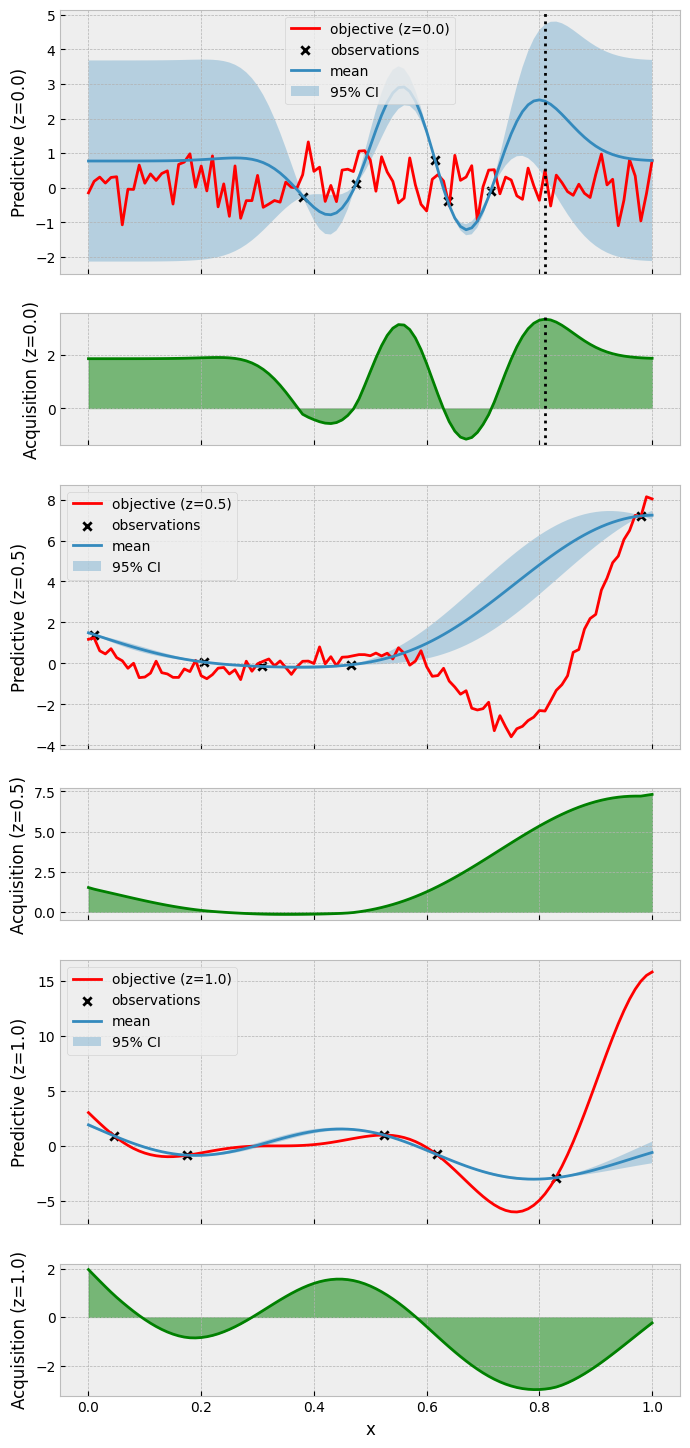

Querying x=0.8102, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([15])
Iteration 2, budget consumed=64.10/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

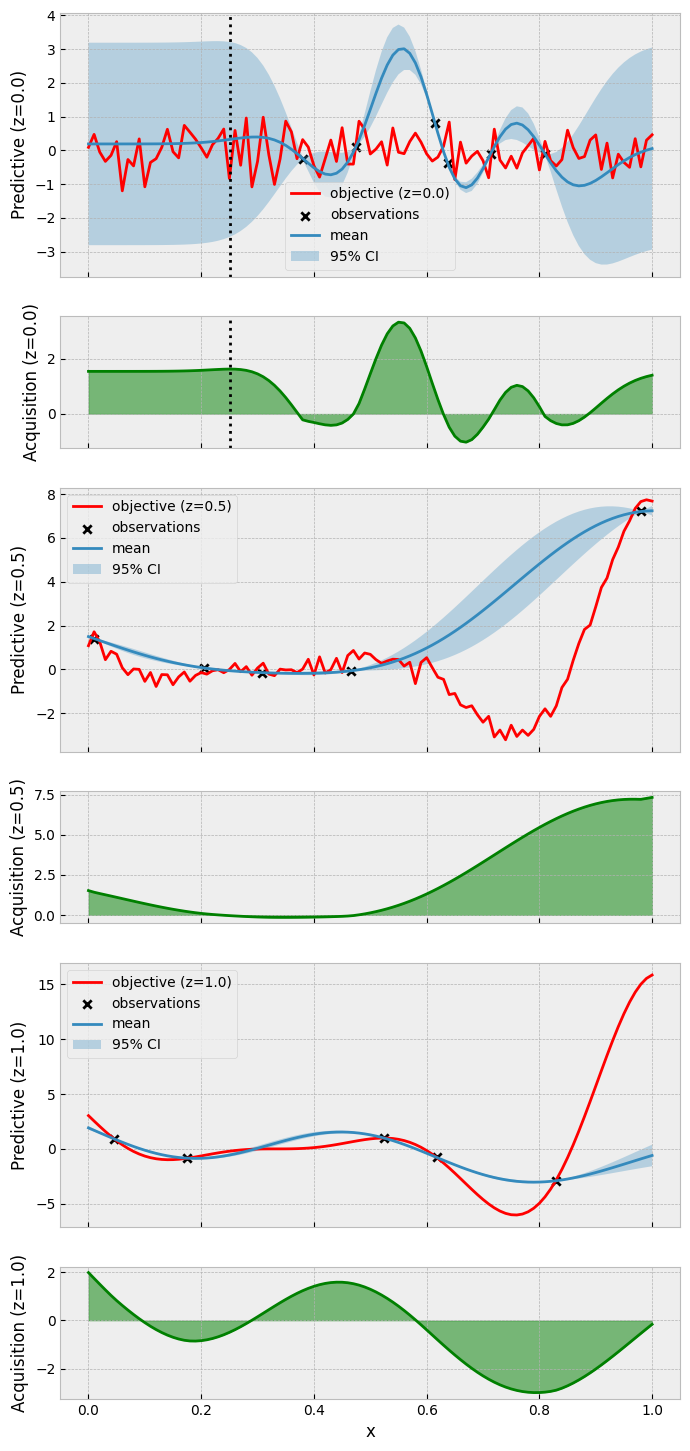

Querying x=0.2517, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([16])
Iteration 3, budget consumed=64.20/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

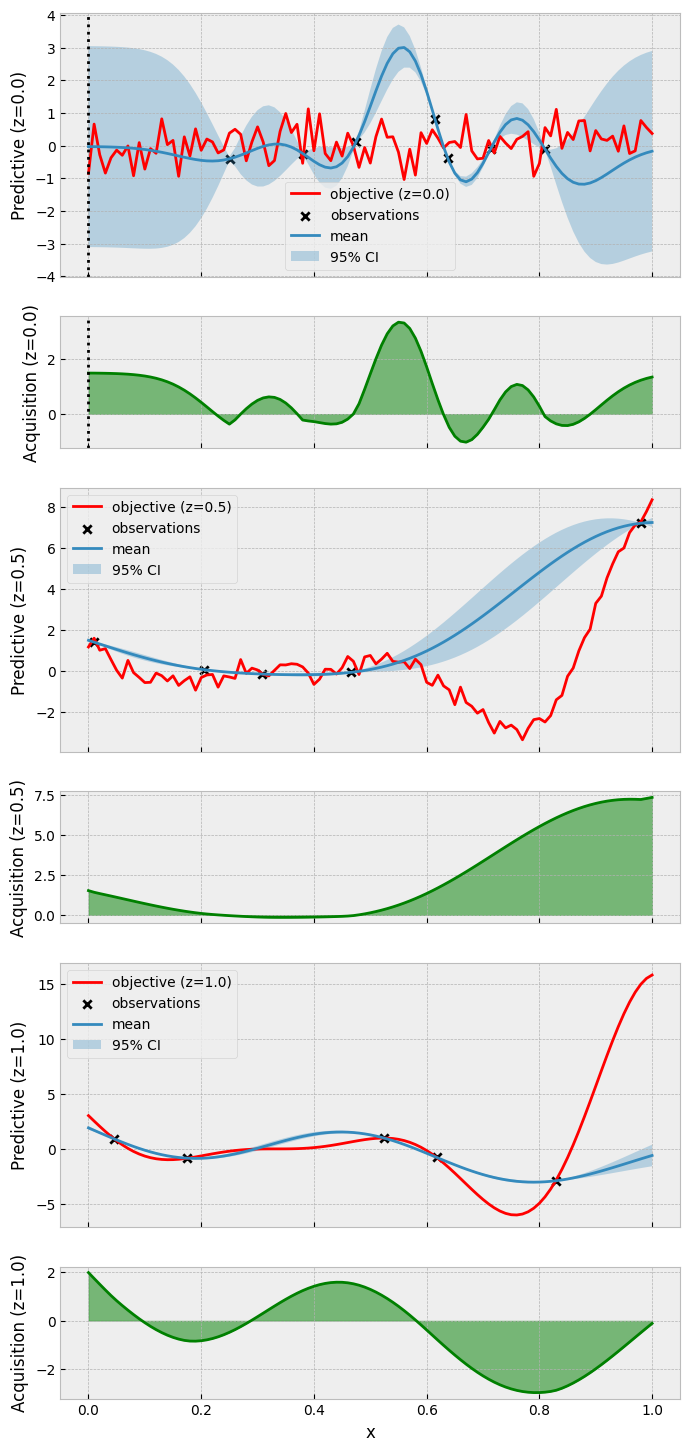

Querying x=0.0000, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([17])
Iteration 4, budget consumed=64.30/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

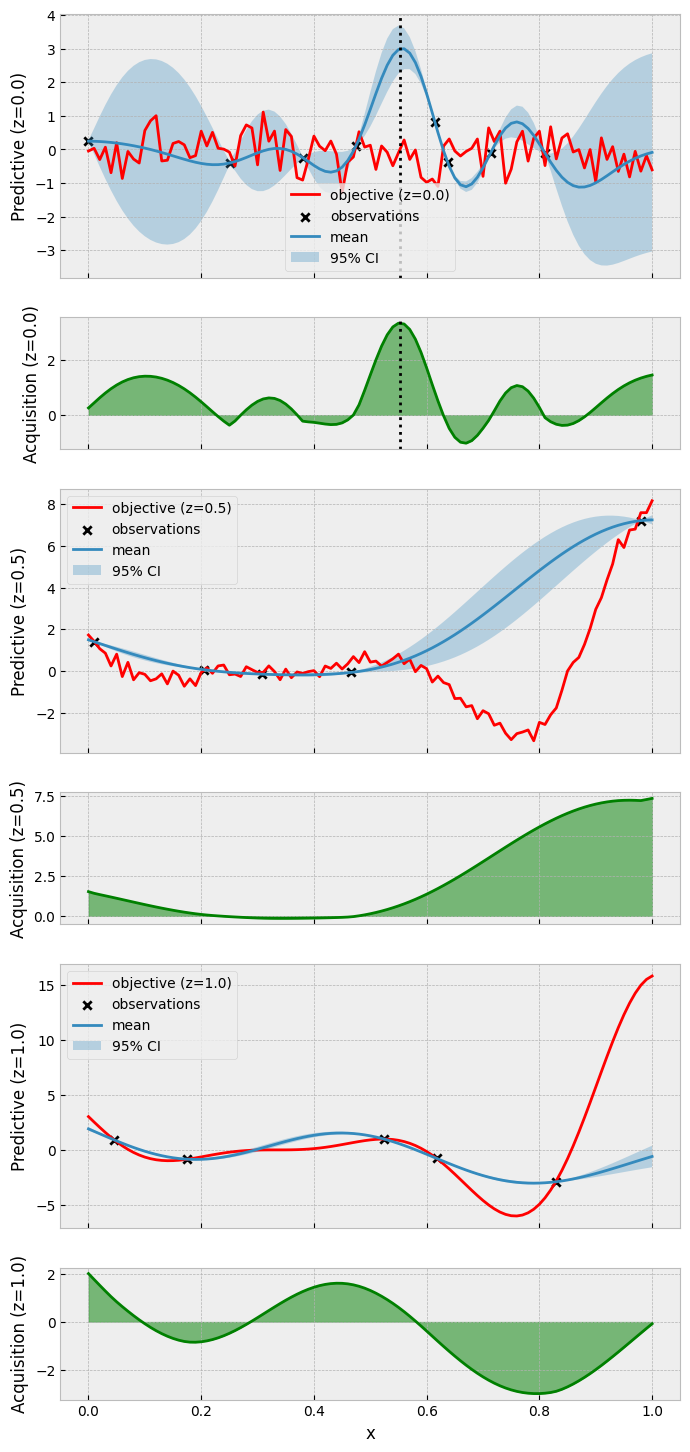

Querying x=0.5532, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([18])
Iteration 5, budget consumed=64.40/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

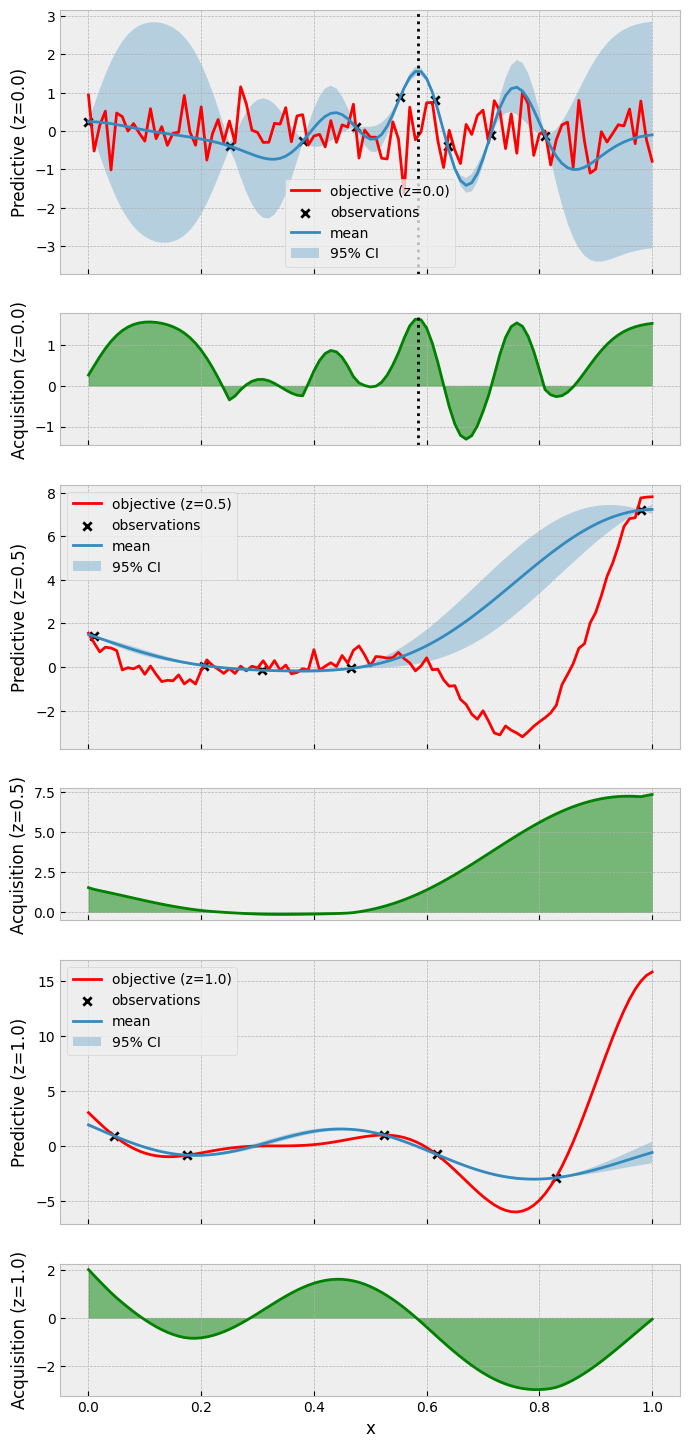

Querying x=0.5842, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([19])
Iteration 6, budget consumed=64.50/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

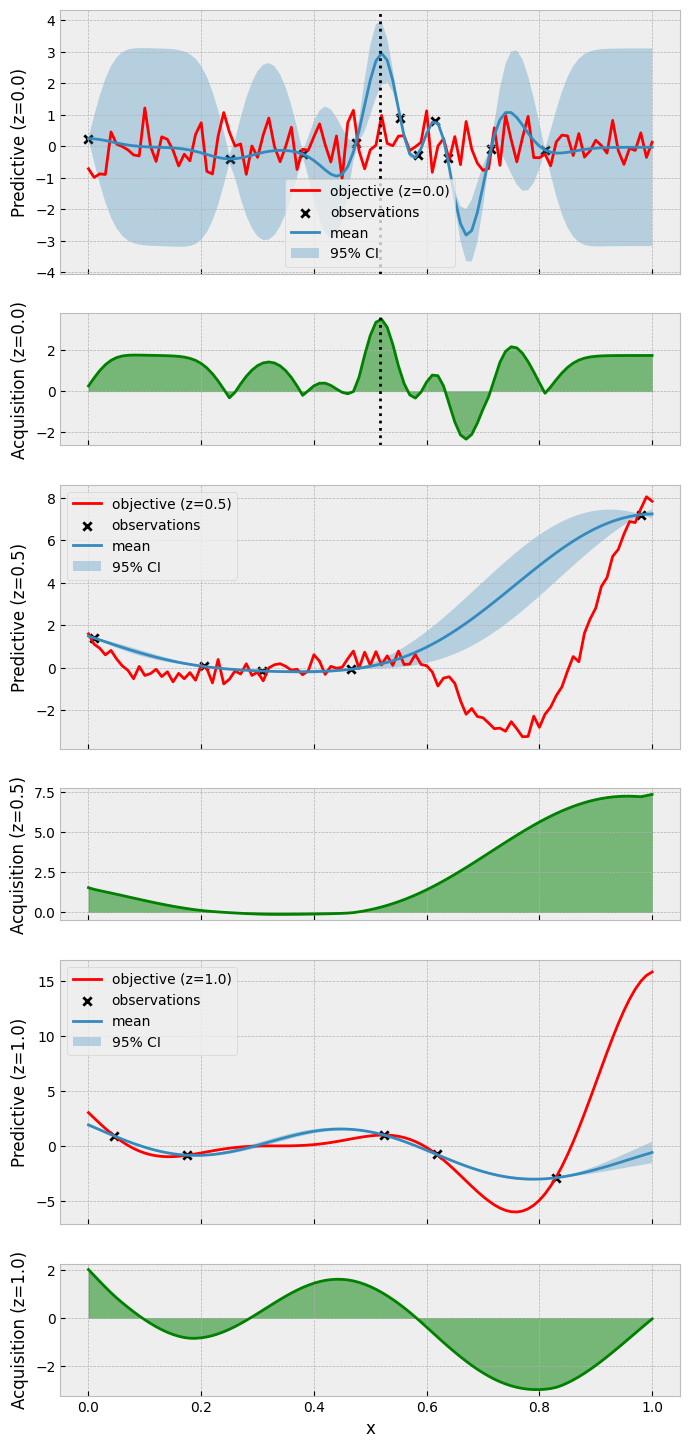

Querying x=0.5178, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([20])
Iteration 7, budget consumed=64.60/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

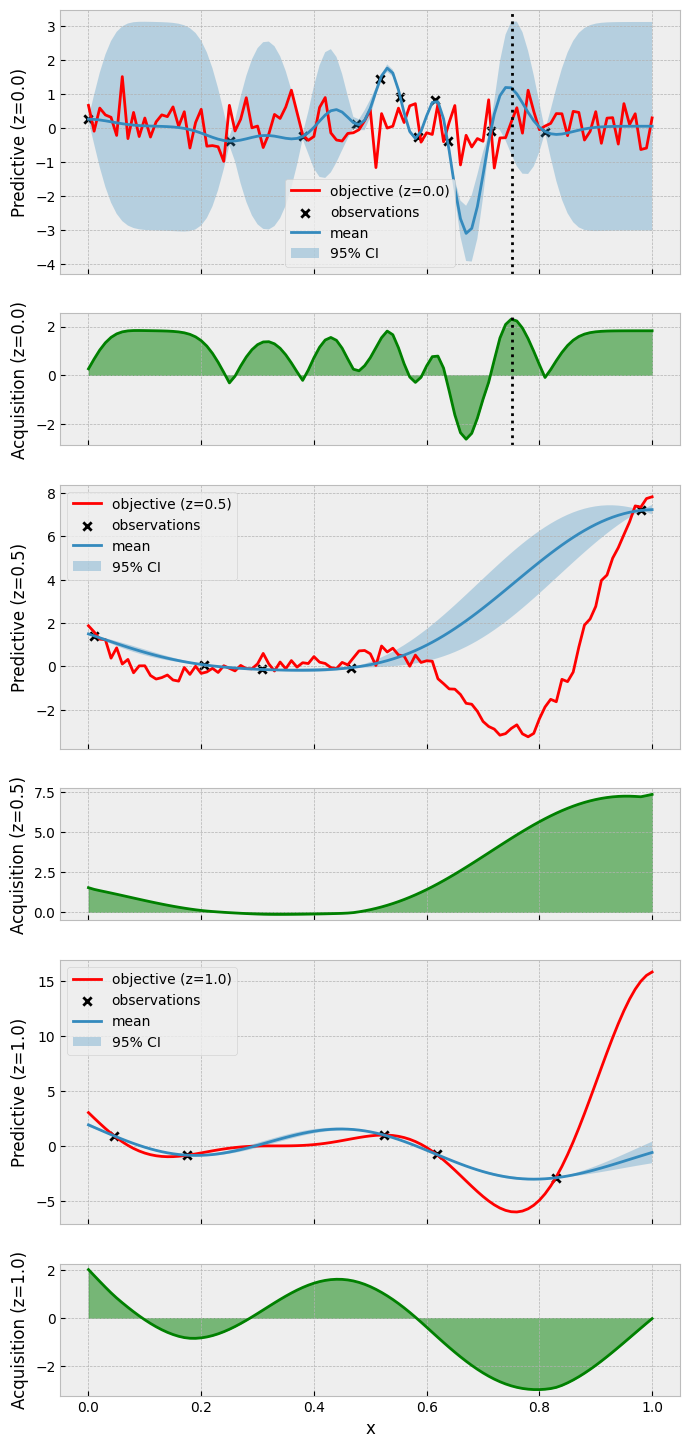

Querying x=0.7521, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([21])
Iteration 8, budget consumed=64.70/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

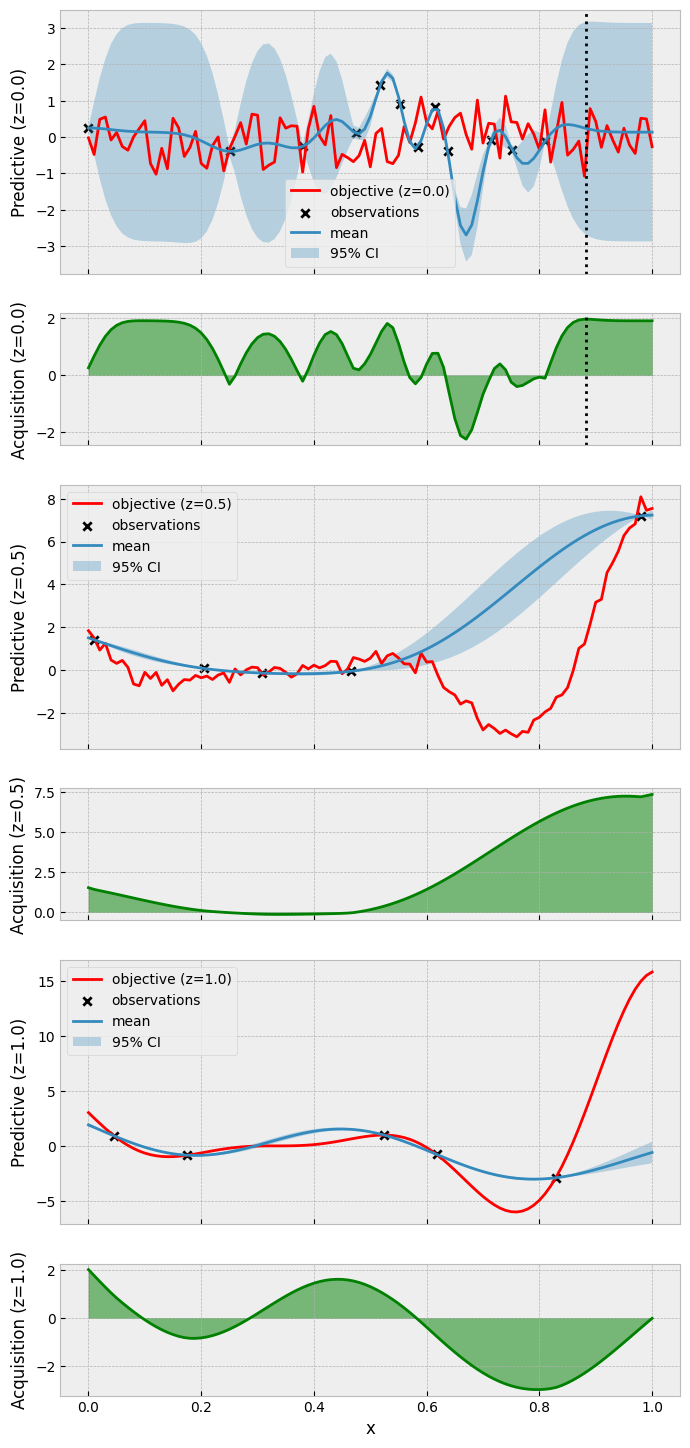

Querying x=0.8833, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([22])
Iteration 9, budget consumed=64.80/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

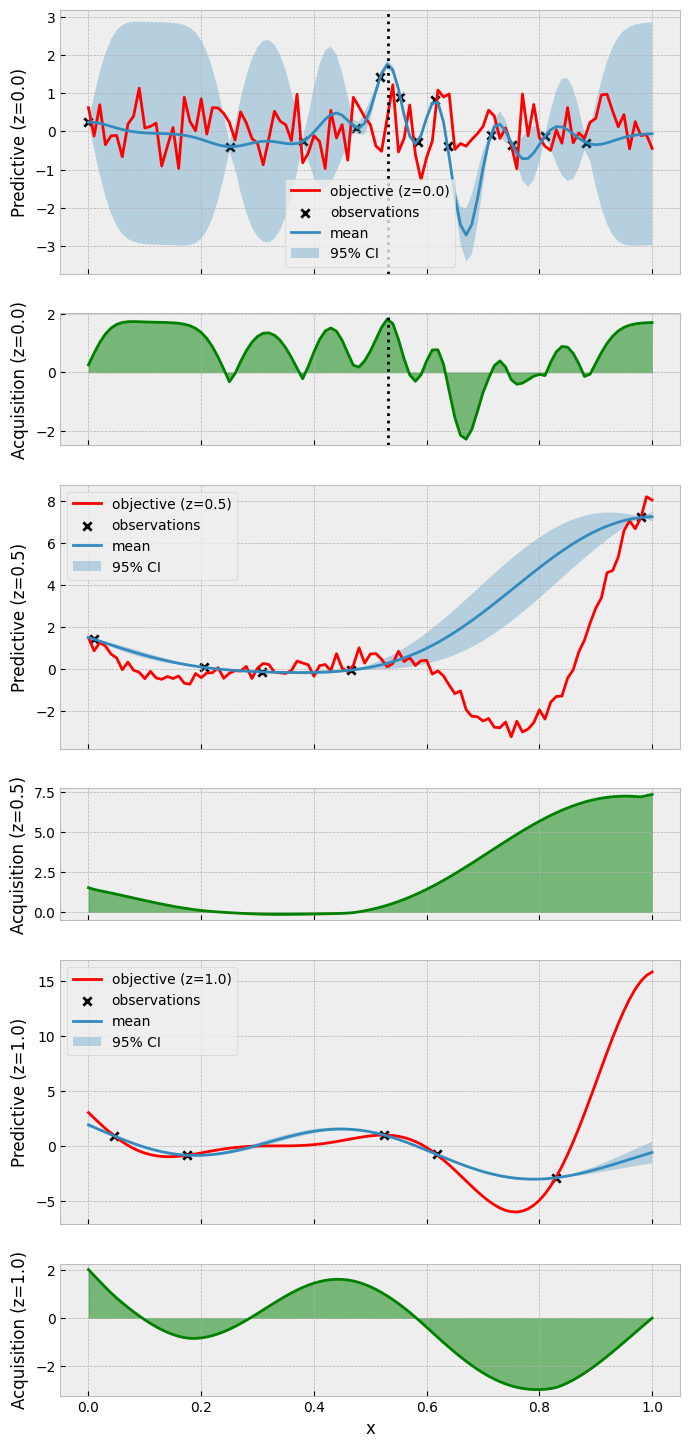

Querying x=0.5317, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([23])
Iteration 10, budget consumed=64.90/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

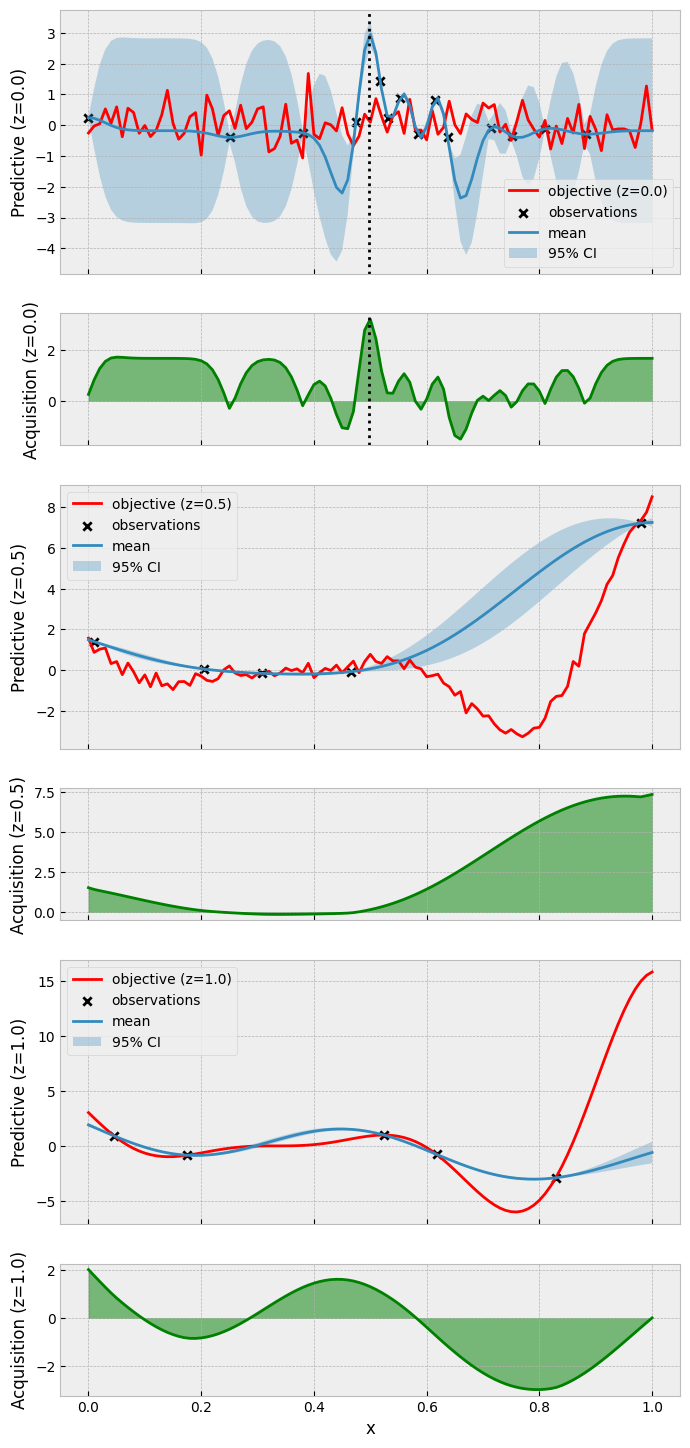

Querying x=0.4983, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([24])
Iteration 11, budget consumed=65.00/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

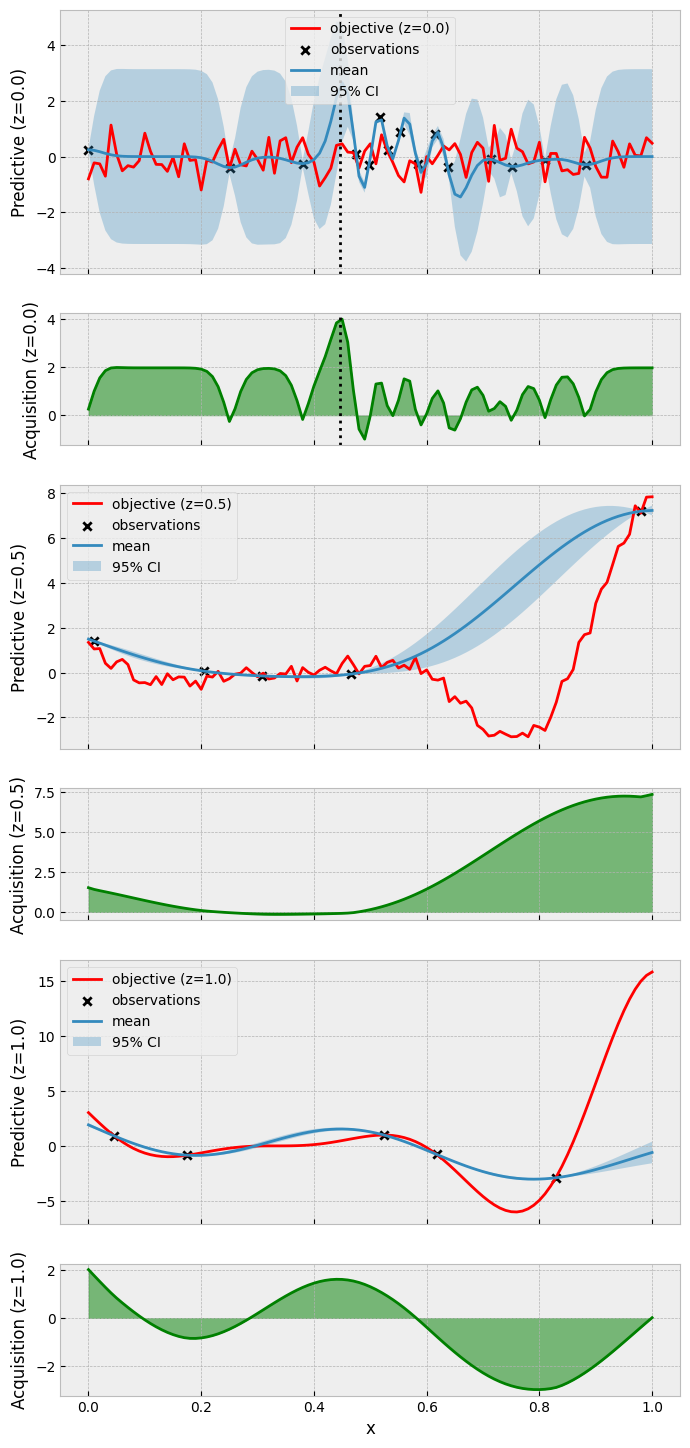

Querying x=0.4469, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([25])
Iteration 12, budget consumed=65.10/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

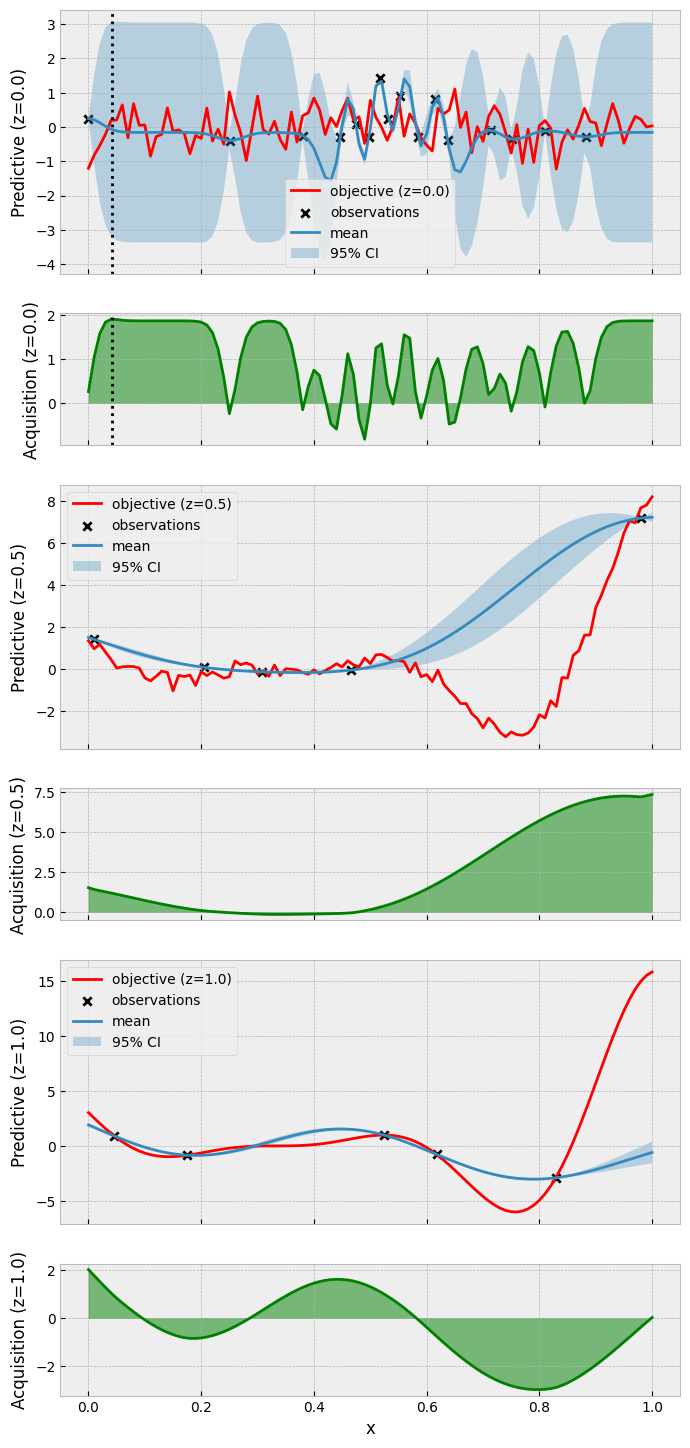

Querying x=0.0425, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([26])
Iteration 13, budget consumed=65.20/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

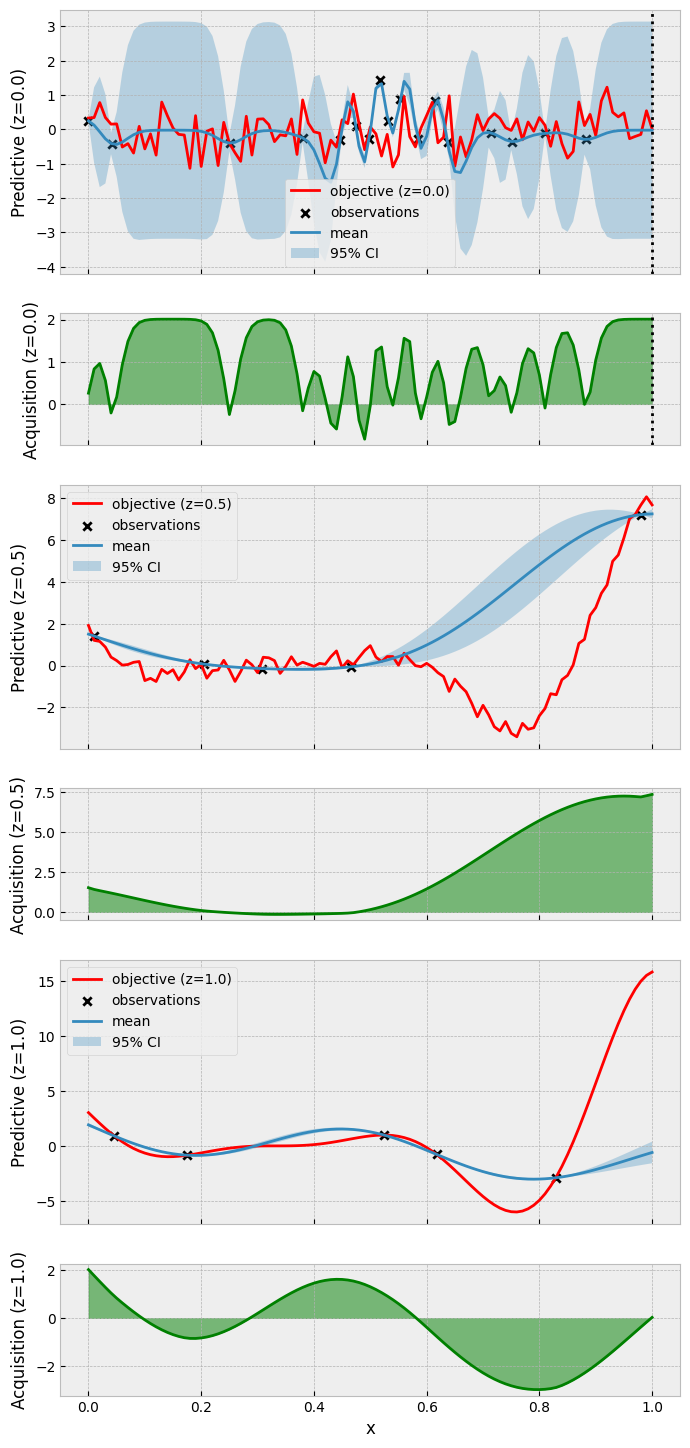

Querying x=1.0000, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([27])
Iteration 14, budget consumed=65.30/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

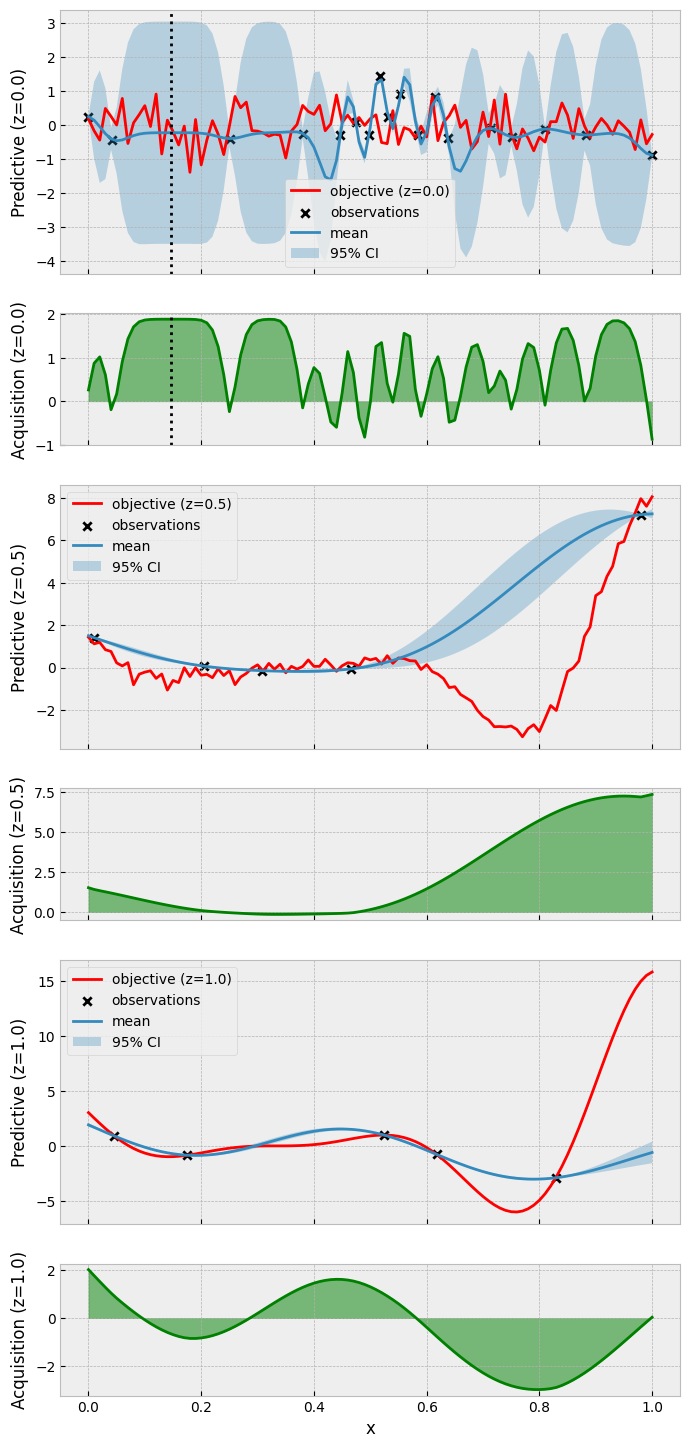

Querying x=0.1462, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([28])
Iteration 15, budget consumed=65.40/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

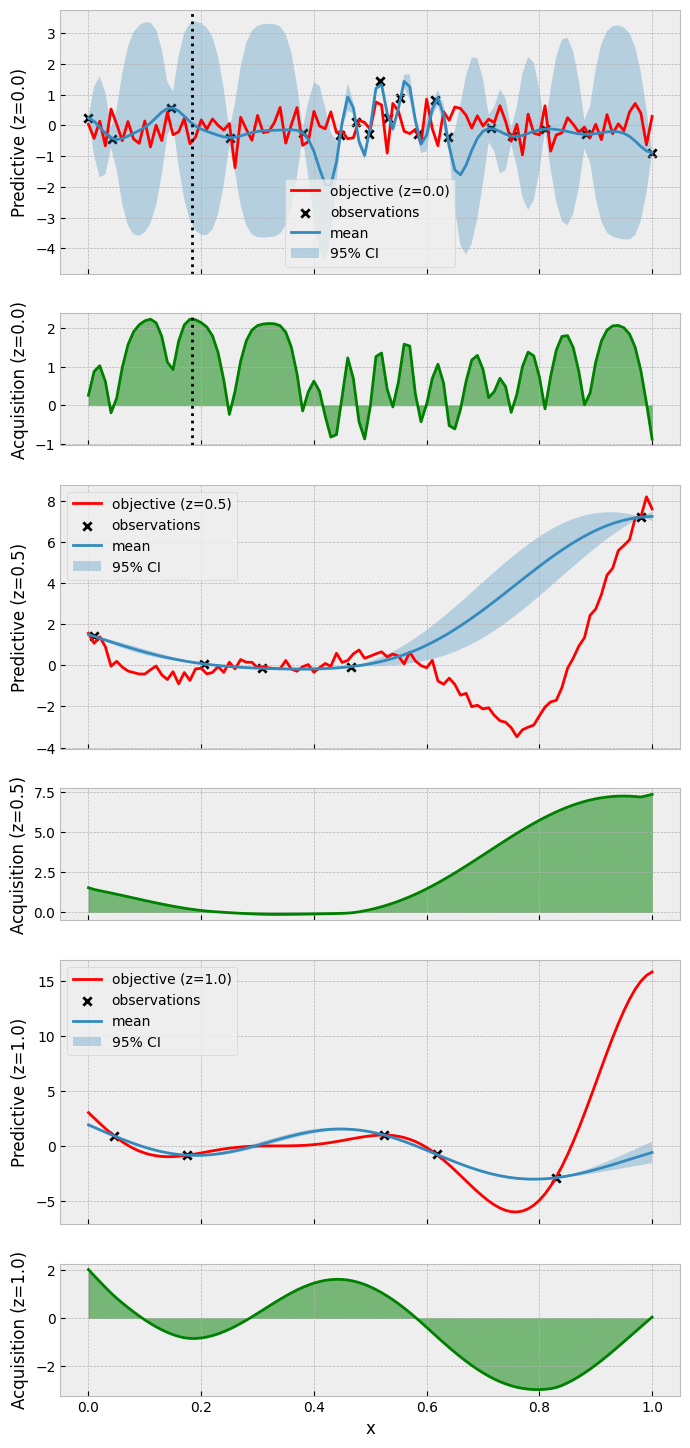

Querying x=0.1833, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([29])
Iteration 16, budget consumed=65.50/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

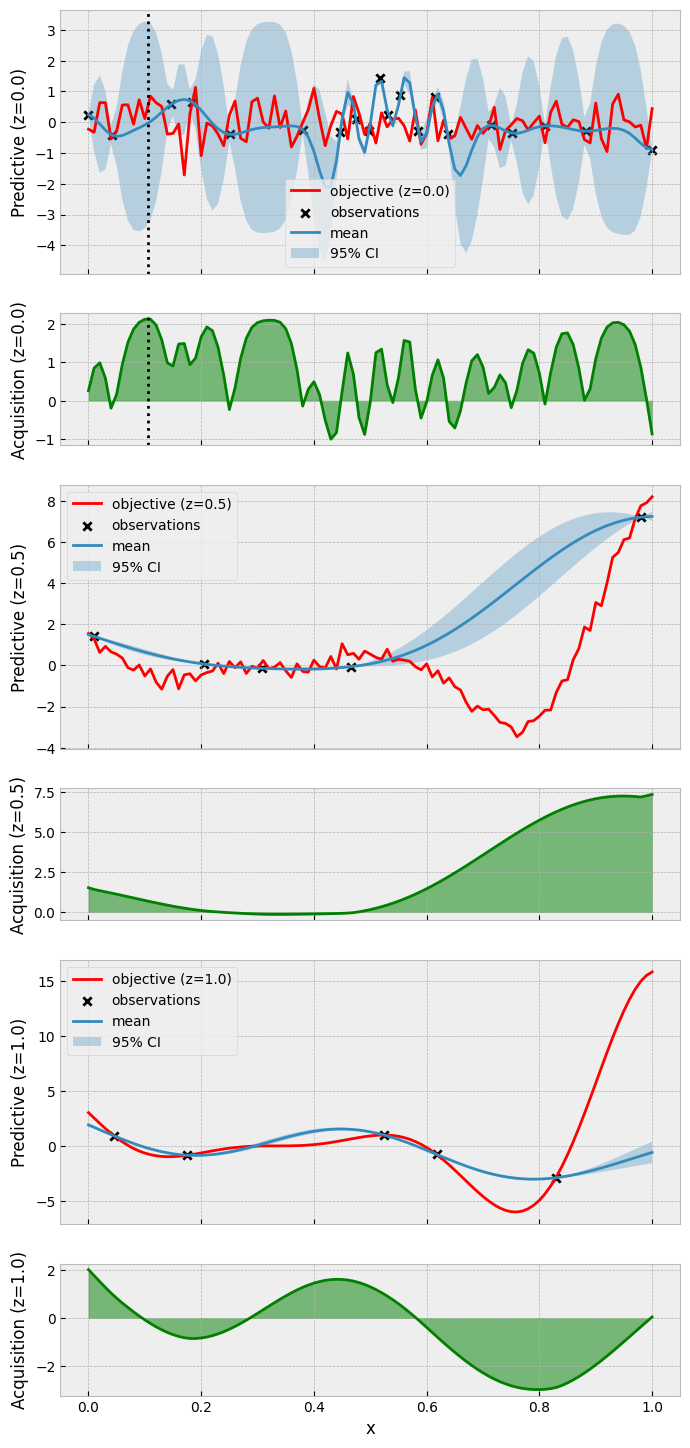

Querying x=0.1052, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([30])
Iteration 17, budget consumed=65.60/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

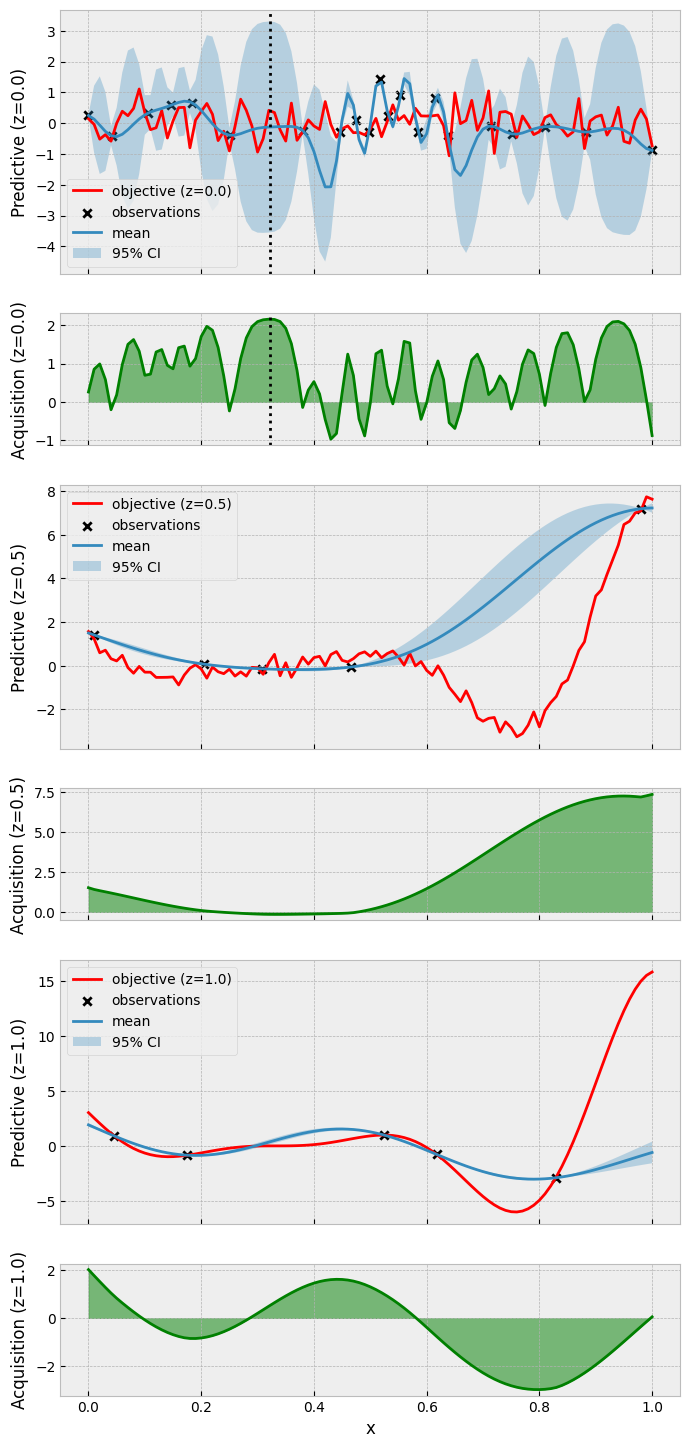

Querying x=0.3226, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([31])
Iteration 18, budget consumed=65.70/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

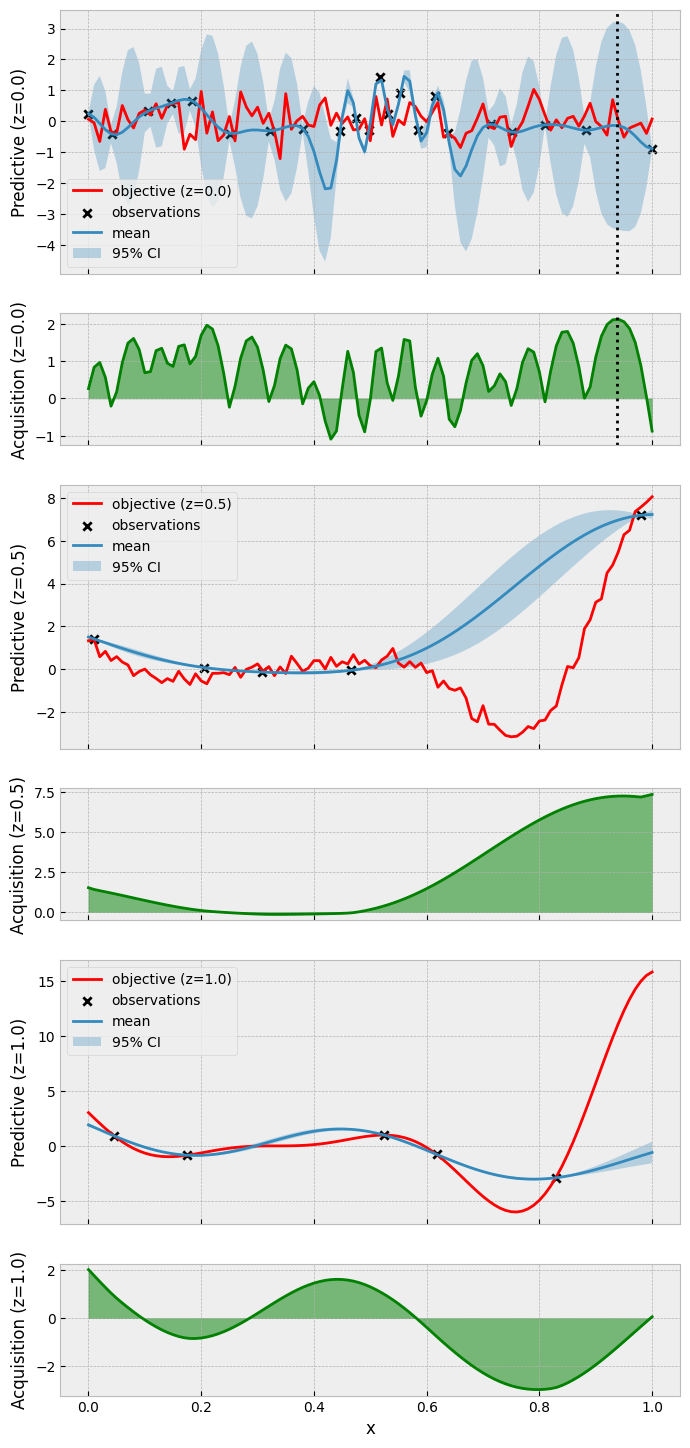

Querying x=0.9370, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([32])
Iteration 19, budget consumed=65.80/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

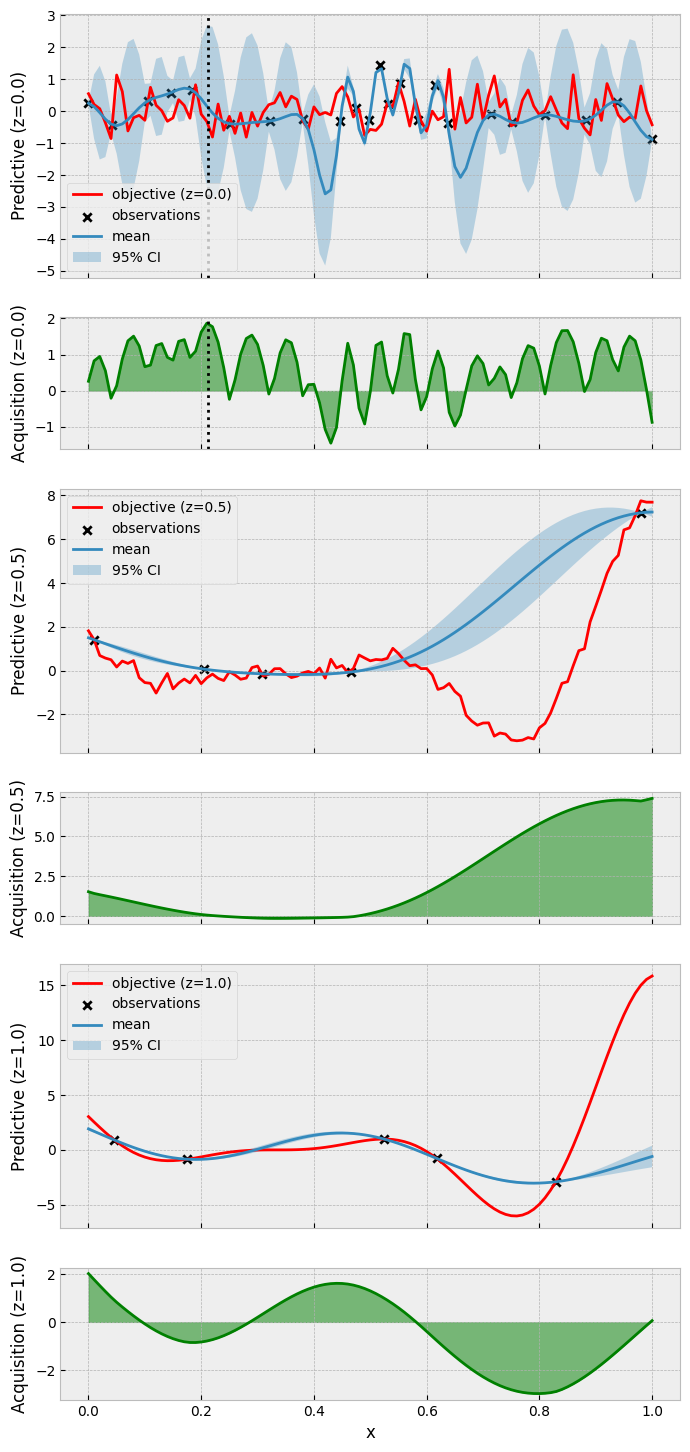

Querying x=0.2122, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([33])
Iteration 20, budget consumed=65.90/100.0, incumbent x=0.8291, f(x)=-2.9029


Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

Training GP:   0%|          | 0/500 [00:00<?, ?it/s]

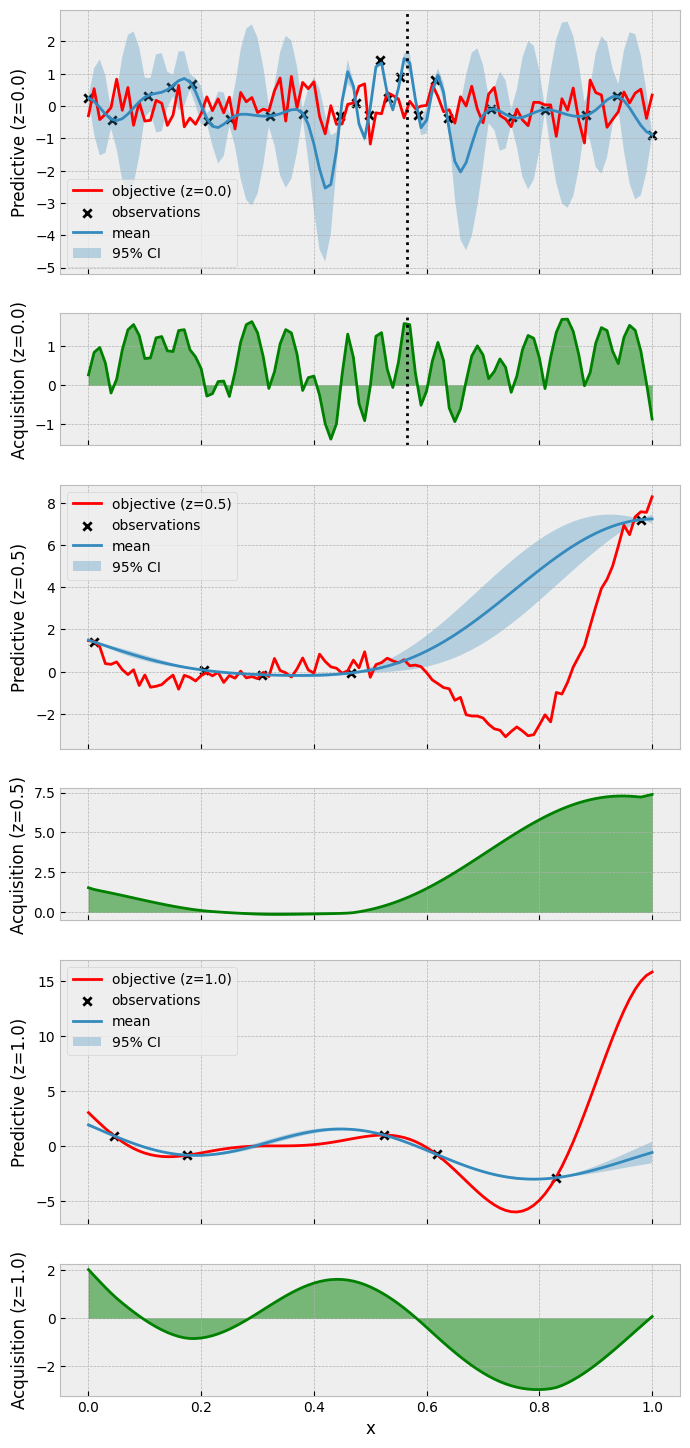

Querying x=0.5649, z=0.0
next_x shape: torch.Size([1, 1]), next_y shape: torch.Size([1]), train_y shape: torch.Size([34])


In [15]:
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("bmh")

from tqdm.notebook import tqdm

class MultiFidelityForrester:
    """Multi-fidelity version of f(x) = (6x - 2)^2 sin(12x - 4), x ∈ [0,1]"""
    def __init__(self, fidelities=[0.0, 0.5, 1.0]):
        self.fidelities = torch.tensor(fidelities)  # Fidelity levels
        self.bounds = torch.tensor([[0.0], [1.0]])  # x in [0,1]
        # Cost function: exponential increase with fidelity
        self.costs = {z: 0.1 + 10 * z**2 for z in fidelities}  # Example from paper: O(z^2)

    def __call__(self, x: torch.Tensor, z: float) -> torch.Tensor:
        """
        Evaluate the Forrester function at fidelity z.
        - z=1.0: True function
        - z<1.0: Approximate by scaling and adding noise
        """
        assert z in self.fidelities, f"Fidelity {z} not in {self.fidelities}"
        true_f = ((6 * x - 2)**2) * torch.sin(12 * x - 4)
        if z == 1.0:
            return true_f.squeeze(-1).flatten()  # Ensure 1D
        scale = z  # Lower fidelity reduces amplitude
        noise = torch.randn_like(true_f) * (1 - z) * 0.5  # Noise increases as z decreases
        return (scale * true_f + noise).squeeze(-1).flatten()  # Ensure 1D

    def get_cost(self, z: float) -> float:
        return self.costs[z]

def visualize_gp_belief_and_policy(models, likelihoods, policies=None, next_x=None, next_z=None):
    """Visualize GP belief for each fidelity and acquisition scores if provided."""
    num_fidelities = len(models)
    xs = torch.linspace(0, 1, 101).unsqueeze(1)
    forrester = MultiFidelityForrester()

    if policies is None:
        fig, axes = plt.subplots(num_fidelities, 1, figsize=(8, 3 * num_fidelities), sharex=True)
        if num_fidelities == 1:
            axes = [axes]  # Ensure axes is iterable for single subplot
        for i, z in enumerate(forrester.fidelities):
            z = z.item()
            with torch.no_grad():
                predictive_distribution = likelihoods[z](models[z](xs))
                predictive_mean = predictive_distribution.mean
                predictive_upper, predictive_lower = predictive_distribution.confidence_region()
            
            train_x_z = train_x[train_z == z]
            train_y_z = train_y[train_z == z]
            
            axes[i].plot(xs, forrester(xs, z), label=f"objective (z={z})", c="r")
            axes[i].scatter(train_x_z, train_y_z, marker="x", c="k", label="observations")
            axes[i].plot(xs, predictive_mean, label="mean")
            axes[i].fill_between(
                xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
            )
            axes[i].legend()
            axes[i].set_ylabel(f"Fidelity z={z}")
        plt.xlabel("x")
        plt.show()
    else:
        fig, axes = plt.subplots(
            num_fidelities * 2, 1, figsize=(8, 6 * num_fidelities), sharex=True,
            gridspec_kw={"height_ratios": [2, 1] * num_fidelities}
        )
        for i, z in enumerate(forrester.fidelities):
            z = z.item()
            with torch.no_grad():
                predictive_distribution = likelihoods[z](models[z](xs))
                predictive_mean = predictive_distribution.mean
                predictive_upper, predictive_lower = predictive_distribution.confidence_region()
                acquisition_score = policies[z](xs.unsqueeze(1)) if z in policies else torch.zeros_like(xs)
            
            train_x_z = train_x[train_z == z]
            train_y_z = train_y[train_z == z]
            
            # GP belief
            axes[2*i].plot(xs, forrester(xs, z), label=f"objective (z={z})", c="r")
            axes[2*i].scatter(train_x_z, train_y_z, marker="x", c="k", label="observations")
            axes[2*i].plot(xs, predictive_mean, label="mean")
            axes[2*i].fill_between(
                xs.flatten(), predictive_upper, predictive_lower, alpha= 0.3, label="95% CI"
            )
            if next_x is not None and next_z == z:
                axes[2*i].axvline(next_x.item(), linestyle="dotted", c="k")
            axes[2*i].legend()
            axes[2*i].set_ylabel(f"Predictive (z={z})")
            
            # Acquisition score
            axes[2*i + 1].plot(xs, acquisition_score, c="g")
            axes[2*i + 1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)
            if next_x is not None and next_z == z:
                axes[2*i + 1].axvline(next_x.item(), linestyle="dotted", c="k")
            axes[2*i + 1].set_ylabel(f"Acquisition (z={z})")
        
        plt.xlabel("x")
        plt.show()

class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    noise = 1e-4
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters), desc="Training GP"):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

# Initialize Forrester function with multiple fidelities
forrester = MultiFidelityForrester(fidelities=[0.0, 0.5, 1.0])
bounds = forrester.bounds  # [0, 1]

# Set up grid for visualization
xs = torch.linspace(bounds[0, 0], bounds[1, 0], 101).unsqueeze(1)

# Parameters
n_initial_points_per_fidelity = 5
num_queries = 20
num_runs = 1
total_budget = 100.0  # Total capital Λ

# MF-GP-UCB parameters (from Kandasamy et al., 2016a)
beta_t = lambda t: 0.5 * 1 * np.log(2 * 1 * t + 1)  # Simplified, d=1
variance_thresholds = {0.0: 0.5, 0.5: 0.2, 1.0: 0.05}  # Variance thresholds

# Store minimum f(x) at highest fidelity for each run
all_min_f_values = []

for run in range(num_runs):
    print(f"\nRun {run + 1}/{num_runs}")
    
    # Set different random seed for each run
    torch.manual_seed(2 + run)
    
    # Initialize with random points at each fidelity
    train_x = []
    train_y = []
    train_z = []
    for z in forrester.fidelities:
        x = torch.rand(size=(n_initial_points_per_fidelity, 1))
        y = forrester(x, z.item())
        train_x.append(x)
        train_y.append(y)
        train_z.append(torch.full((n_initial_points_per_fidelity,), z.item()))
    
    train_x = torch.cat(train_x)
    train_y = torch.cat(train_y)
    train_z = torch.cat(train_z)
    
    # Track consumed budget
    consumed_budget = sum(forrester.get_cost(z.item()) for z in train_z)
    
    # Fit initial GP models for each fidelity
    models = {}
    likelihoods = {}
    for z in forrester.fidelities:
        z = z.item()
        idx = train_z == z
        model, likelihood = fit_gp_model(train_x[idx], train_y[idx])
        models[z] = model
        likelihoods[z] = likelihood
    
    # Track minimum f(x) at highest fidelity
    high_fidelity_idx = train_z == 1.0
    min_f_values = [train_y[high_fidelity_idx].min().item()] if high_fidelity_idx.sum() > 0 else [float('inf')]
    
    # Run MF-GP-UCB
    t = 1
    while consumed_budget < total_budget and t <= num_queries:
        print(f"Iteration {t}, budget consumed={consumed_budget:.2f}/{total_budget}, "
              f"incumbent x={train_x[train_y.argmin()].item():.4f}, f(x)={train_y.min().item():.4f}")
        
        # Fit GP models
        for z in forrester.fidelities:
            z = z.item()
            idx = train_z == z
            if idx.sum() > 0:
                models[z], likelihoods[z] = fit_gp_model(train_x[idx], train_y[idx])
        
        # Compute UCB for each fidelity
        policies = {}
        for z in forrester.fidelities:
            z = z.item()
            policies[z] = botorch.acquisition.analytic.UpperConfidenceBound(
                models[z], beta=beta_t(t)
            )
        
        # Select next point and fidelity
        best_value = -float('inf')
        next_x = None
        next_z = None
        
        for z in forrester.fidelities:
            z = z.item()
            can_query = True
            for z_lower in forrester.fidelities:
                z_lower = z_lower.item()
                if z_lower >= z:
                    continue
                idx = train_z == z_lower
                if idx.sum() == 0:
                    can_query = False
                    break
                posterior_variance = likelihoods[z_lower](models[z_lower](xs)).variance
                if posterior_variance.max() > variance_thresholds[z_lower]:
                    can_query = False
                    break
            
            if not can_query:
                continue
            
            candidate_x, acq_value = botorch.optim.optimize_acqf(
                policies[z],
                bounds=bounds,
                q=1,
                num_restarts=20,
                raw_samples=50,
            )
            
            adjusted_value = acq_value / forrester.get_cost(z)
            if adjusted_value > best_value:
                best_value = adjusted_value
                next_x = candidate_x
                next_z = z
        
        if next_x is None:
            z = 1.0
            candidate_x, acq_value = botorch.optim.optimize_acqf(
                policies[z],
                bounds=bounds,
                q=1,
                num_restarts=20,
                raw_samples=50,
            )
            next_x = candidate_x
            next_z = z
        
        # Visualize
        visualize_gp_belief_and_policy(models, likelihoods, policies, next_x, next_z)
        
        # Query the function
        print(f"Querying x={next_x.item():.4f}, z={next_z}")
        next_y = forrester(next_x, next_z)
        consumed_budget += forrester.get_cost(next_z)
        
        # Debug shapes
        print(f"next_x shape: {next_x.shape}, next_y shape: {next_y.shape}, train_y shape: {train_y.shape}")
        
        # Update data
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])
        train_z = torch.cat([train_z, torch.tensor([next_z])])
        
        # Update minimum f(x) at highest fidelity
        high_fidelity_idx = train_z == 1.0
        if high_fidelity_idx.sum() > 0:
            min_f_values.append(train_y[high_fidelity_idx].min().item())
        else:
            min_f_values.append(min_f_values[-1])
        
        t += 1
    
    # Store results for this run
    all_min_f_values.append(min_f_values)
    
    # Plot minimum f(x) vs iteration for this run
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(min_f_values)), min_f_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Iteration')
    plt.ylabel('Minimum f(x) at z=1.0')
    plt.title(f'Minimum f(x) vs Iteration (Run {run + 1})')
    plt.grid(True)
    plt.savefig(f'min_f_vs_iteration_run_{run + 1}_mf.png')
    plt.close()

# Pad sequences to the same length
max_length = max(len(run) for run in all_min_f_values)
all_min_f_values_padded = []
for run in all_min_f_values:
    padded = np.pad(run, (0, max_length - len(run)), mode='edge')
    all_min_f_values_padded.append(padded)
all_min_f_values = np.array(all_min_f_values_padded)

# Compute mean, std, and 95% CI
mean_f = np.mean(all_min_f_values, axis=0)
std_f = np.std(all_min_f_values, axis=0)
ci_95 = 1.96 * std_f / np.sqrt(num_runs)

# Plot convergence
plt.figure(figsize=(10, 6))
iterations = range(max_length)

plt.plot(iterations, mean_f, marker='o', linestyle='-', color='b', label='Mean Minimum f(x)')
plt.fill_between(
    iterations,
    mean_f - ci_95,
    mean_f + ci_95,
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.fill_between(
    iterations,
    mean_f - std_f,
    mean_f + std_f,
    color='g',
    alpha=0.1,
    label='Mean ± Std'
)

plt.xlabel('Iteration')
plt.ylabel('Minimum f(x) at z=1.0')
plt.title('Convergence Plot: Mean, Std, and 95% CI over 10 Runs (MF-GP-UCB)')
plt.grid(True)
plt.legend()
plt.savefig('convergence_plot_mf.png')
plt.close()

In [8]:
import botorch
print(botorch.__version__)

0.14.0
